# Flow Metrics

## Data Review

In [1]:
import matplotlib
import pandas
import seaborn
import collections

In [2]:
import analysis
analysis.init()

In [3]:
OMIT_ISSUE_TYPES = ('Epic')
FILTER_ISSUES_UNTIL = '2023-05-02'
FILTER_ISSUES_SINCE = '2023-04-15'
EXCLUDE_WEEKENDS = False
DATA_FILE = 'jira_output_data.csv'
STATUS_ORDER = ['Selected for Development', 'In Progress', 'In Review', 'Done']

In [4]:
data, dupes, filtered = analysis.read_data(DATA_FILE, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)

# Additional Filters
# data.loc[data['status_to_name'] == 'Removed', 'status_to_category_name'] = 'Done'
# data = data[data['project_key'] == 'Development']
# data = data[data['issue_type_name'] != 'Task']
# data = data[data['issue_type_name'] != 'Epic']
# data = data[data['issue_type_name'] != 'Definition Item']
# data = data[data['issue_type_name'] != 'Test Suite']
# data = data[data['issue_type_name'] != 'User Story']
# data = data.dropna(subset=['changelog_id'])
# data = data.dropna(subset=['issue_id'])
# data['issue_points'] = data['custom_estimated_effort']
# data['issue_points'] = data['custom_original_estimate']

data.head(1)

,project_id,project_key,issue_id,issue_key,issue_type_id,issue_type_name,issue_title,issue_created_date,changelog_id,status_from_id,status_from_name,status_to_id,status_to_name,status_from_category_name,status_to_category_name,status_change_date,issue_points
42,10035,SKP,10047,SKP-1,10002,Task,Kanban cards represent work items >> Click the...,2023-04-29 07:58:34.350,10271.0,10000.0,Backlog,10001.0,Selected for Development,To Do,To Do,2023-04-30 14:17:53.482,1


In [5]:
print(f"{dupes} duplicates removed from the dataset")

0 duplicates removed from the dataset


In [6]:
collections.Counter(data['issue_type_name'].values)

Counter({'Bug': 24, 'Task': 21, 'Story': 11})

In [7]:
collections.Counter(list(data['status_from_name'].values) + list(data['status_to_name'].values))

Counter({'Selected for Development': 32,
         'In Progress': 32,
         'Backlog': 21,
         nan: 12,
         'Done': 11,
         'In Review': 4})

In [8]:
collections.Counter(data['issue_points'].dropna().values)

Counter({1: 56})

## Calculation

In [9]:
issue_data, (categories, *extra) = analysis.process_issue_data(data, exclude_weekends=EXCLUDE_WEEKENDS)
issue_data.head(1)

,issue_type,issue_points,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days,in progress,prev_issue_status,prev_issue_status_change_date,prev_issue_status_category,last_issue_status,last_issue_status_change_date,last_issue_status_category
issue_key,,,,,,,,,,,,,,,,,,,
SKP-1,Task,1.0,2023-04-29 07:58:34.350,2023-04-29,2023-04-30 14:38:01.808,2023-04-30,2023-04-30 16:35:54.872,2023-04-30,1 days 08:37:20.522000,1.359265,0 days 01:57:53.064000,0.081864,NaN,In Progress,2023-04-30 14:38:01.808,In Progress,Done,2023-04-30 16:35:54.872,Done


In [10]:
collections.Counter(issue_data['last_issue_status'].values)

Counter({'Done': 11,
         nan: 6,
         'In Review': 4,
         'Selected for Development': 3,
         'In Progress': 2})

In [11]:
categories

defaultdict(set,
            {'To Do': {'Backlog', 'Selected for Development'},
             'In Progress': {'In Progress', 'In Review'},
             'Done': {'Done'},
             nan: {nan}})

## Metrics Visualization

### Cycle Time

In [12]:
cycle_data = analysis.process_cycle_data(issue_data)
cycle_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, SKP-16 to SKP-21
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype        
---  ------                                --------------  -----        
 0   In Progress Date                      11 non-null     datetime64[s]
 1   Complete Date                         11 non-null     datetime64[s]
 2   Cycle Time                            11 non-null     float64      
 3   Moving Average (10 items)             2 non-null      float64      
 4   Moving Standard Deviation (10 items)  2 non-null      float64      
 5   Average                               11 non-null     float64      
 6   Standard Deviation                    11 non-null     float64      
dtypes: datetime64[s](2), float64(5)
memory usage: 704.0+ bytes


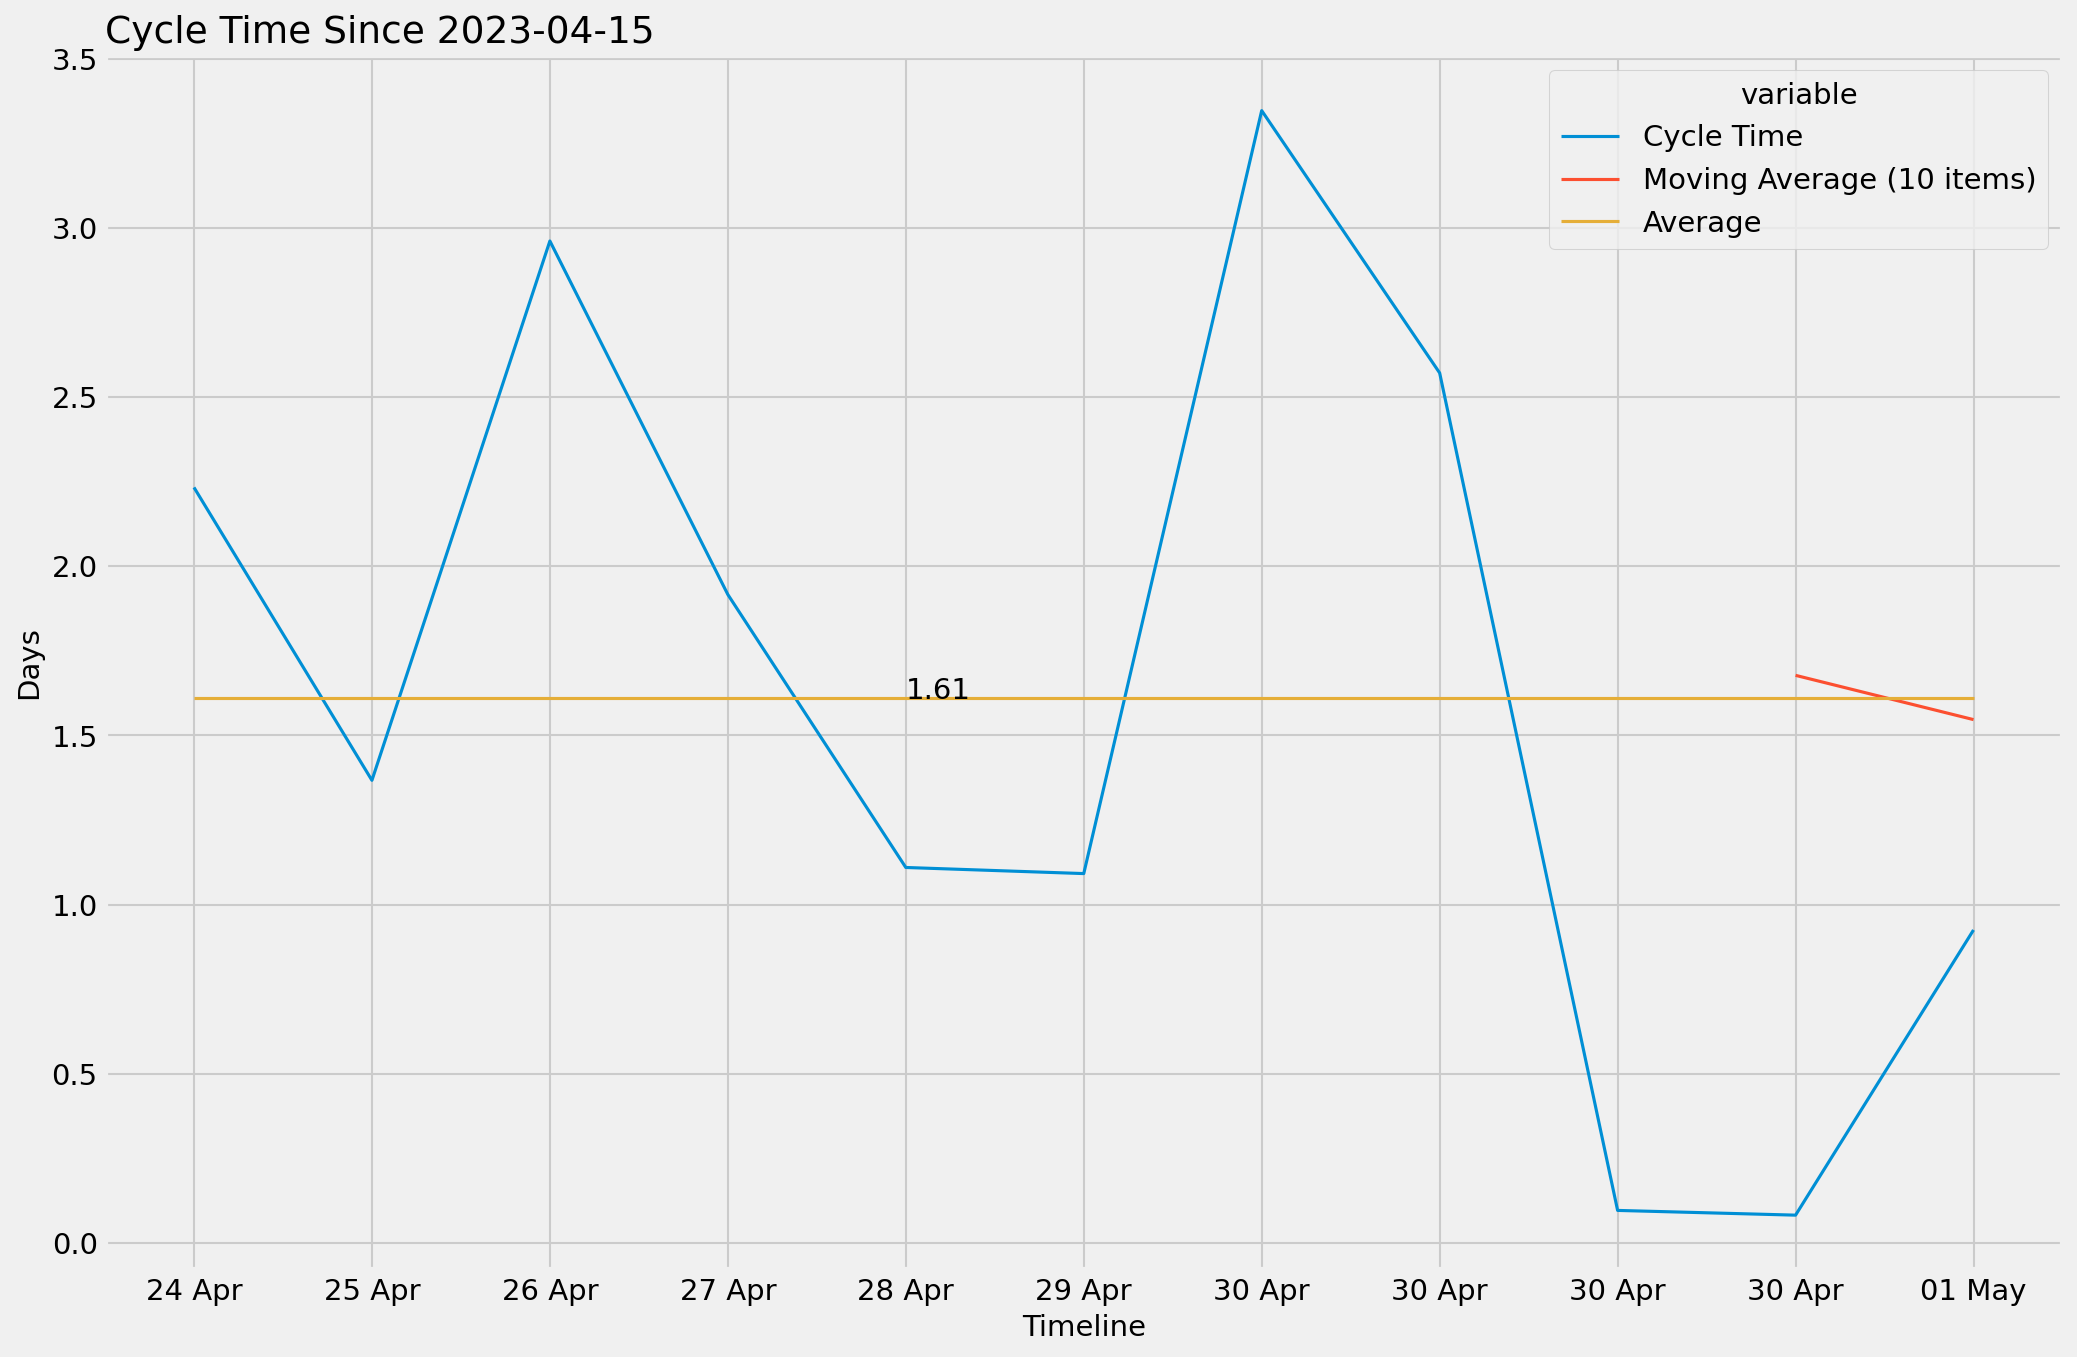

In [13]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

cycle_data = cycle_data.reset_index()

ax = seaborn.lineplot(x='Work Item',
                      y='value',
                      hue='variable',
                      data=pandas.melt(
                              cycle_data[['Work Item',
                                          'Cycle Time',
                                          'Moving Average (10 items)',
                                          'Average']],
                            ['Work Item']))

ax.set_title(f"Cycle Time Since {FILTER_ISSUES_SINCE}",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Days')

key_ticks = range(0, len(cycle_data['Work Item']), len(cycle_data['Work Item'])//10)

ax.set_xticks(key_ticks)

def format_func(value, tick_number):
    return pandas.to_datetime(cycle_data['Complete Date'].values[value]).strftime('%d %b')
ax.xaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))

_ = ax.text(cycle_data['Work Item'].max(), cycle_data['Average'].max(), "{:.2f}".format(cycle_data['Average'].max()))

In [14]:
ax.figure.savefig('images/cycletime-timeline.png', dpi=150)

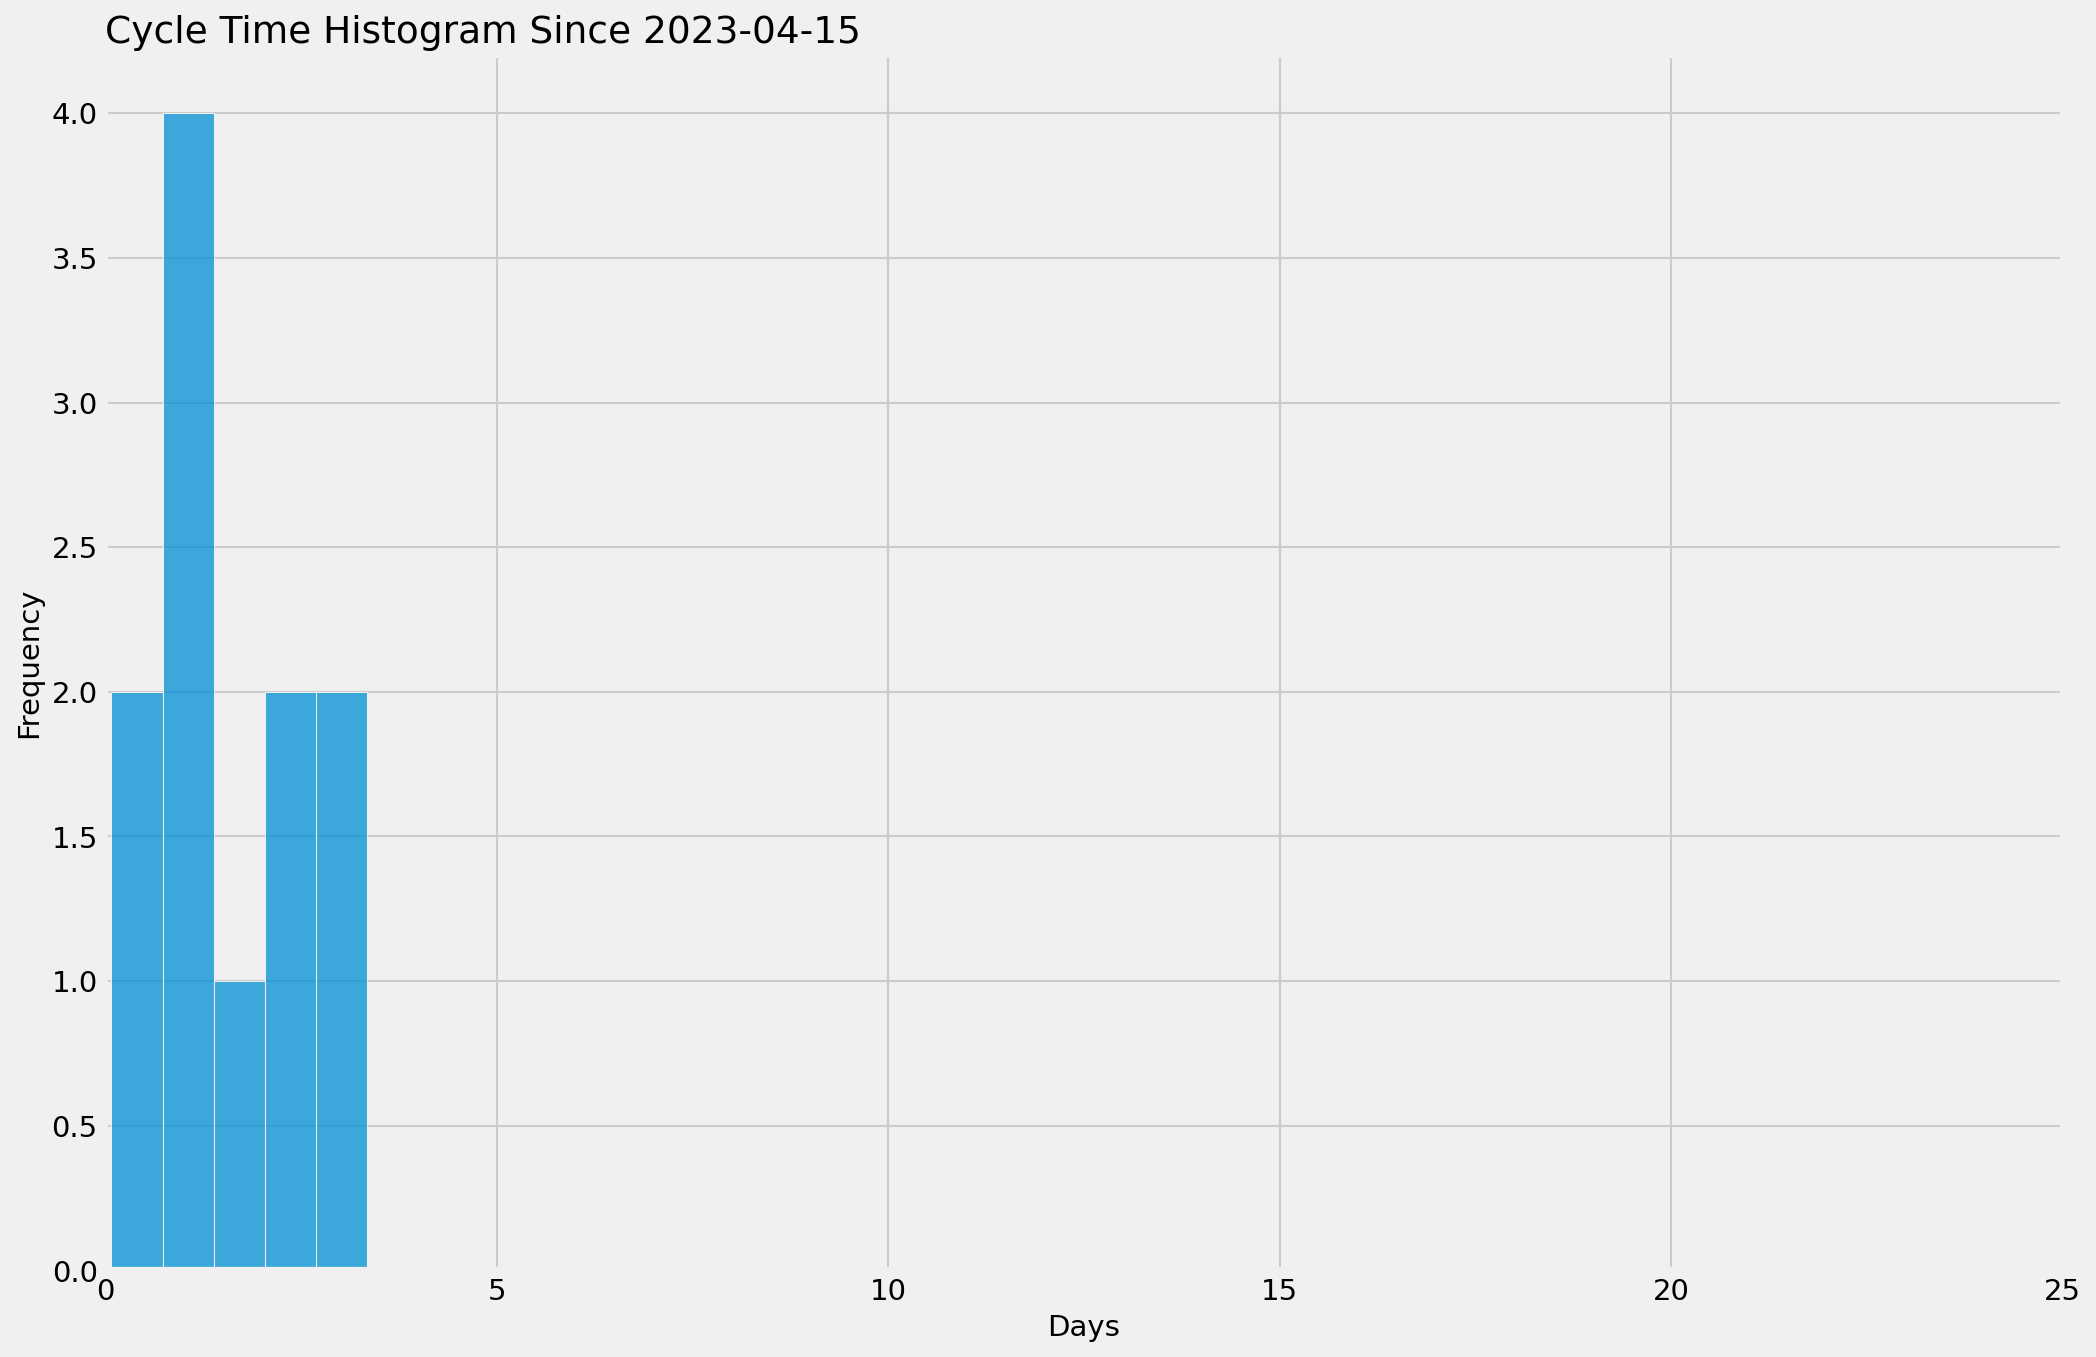

In [15]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.histplot(cycle_data['Cycle Time'], bins=5, kde=False)

ax.set_title(f"Cycle Time Histogram Since {FILTER_ISSUES_SINCE}",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

ax.set_ylabel('Frequency')
ax.set_xlabel('Days')
_ = ax.set_xlim([0, 25])

In [16]:
ax.figure.savefig('images/cycletime-histogram.png')

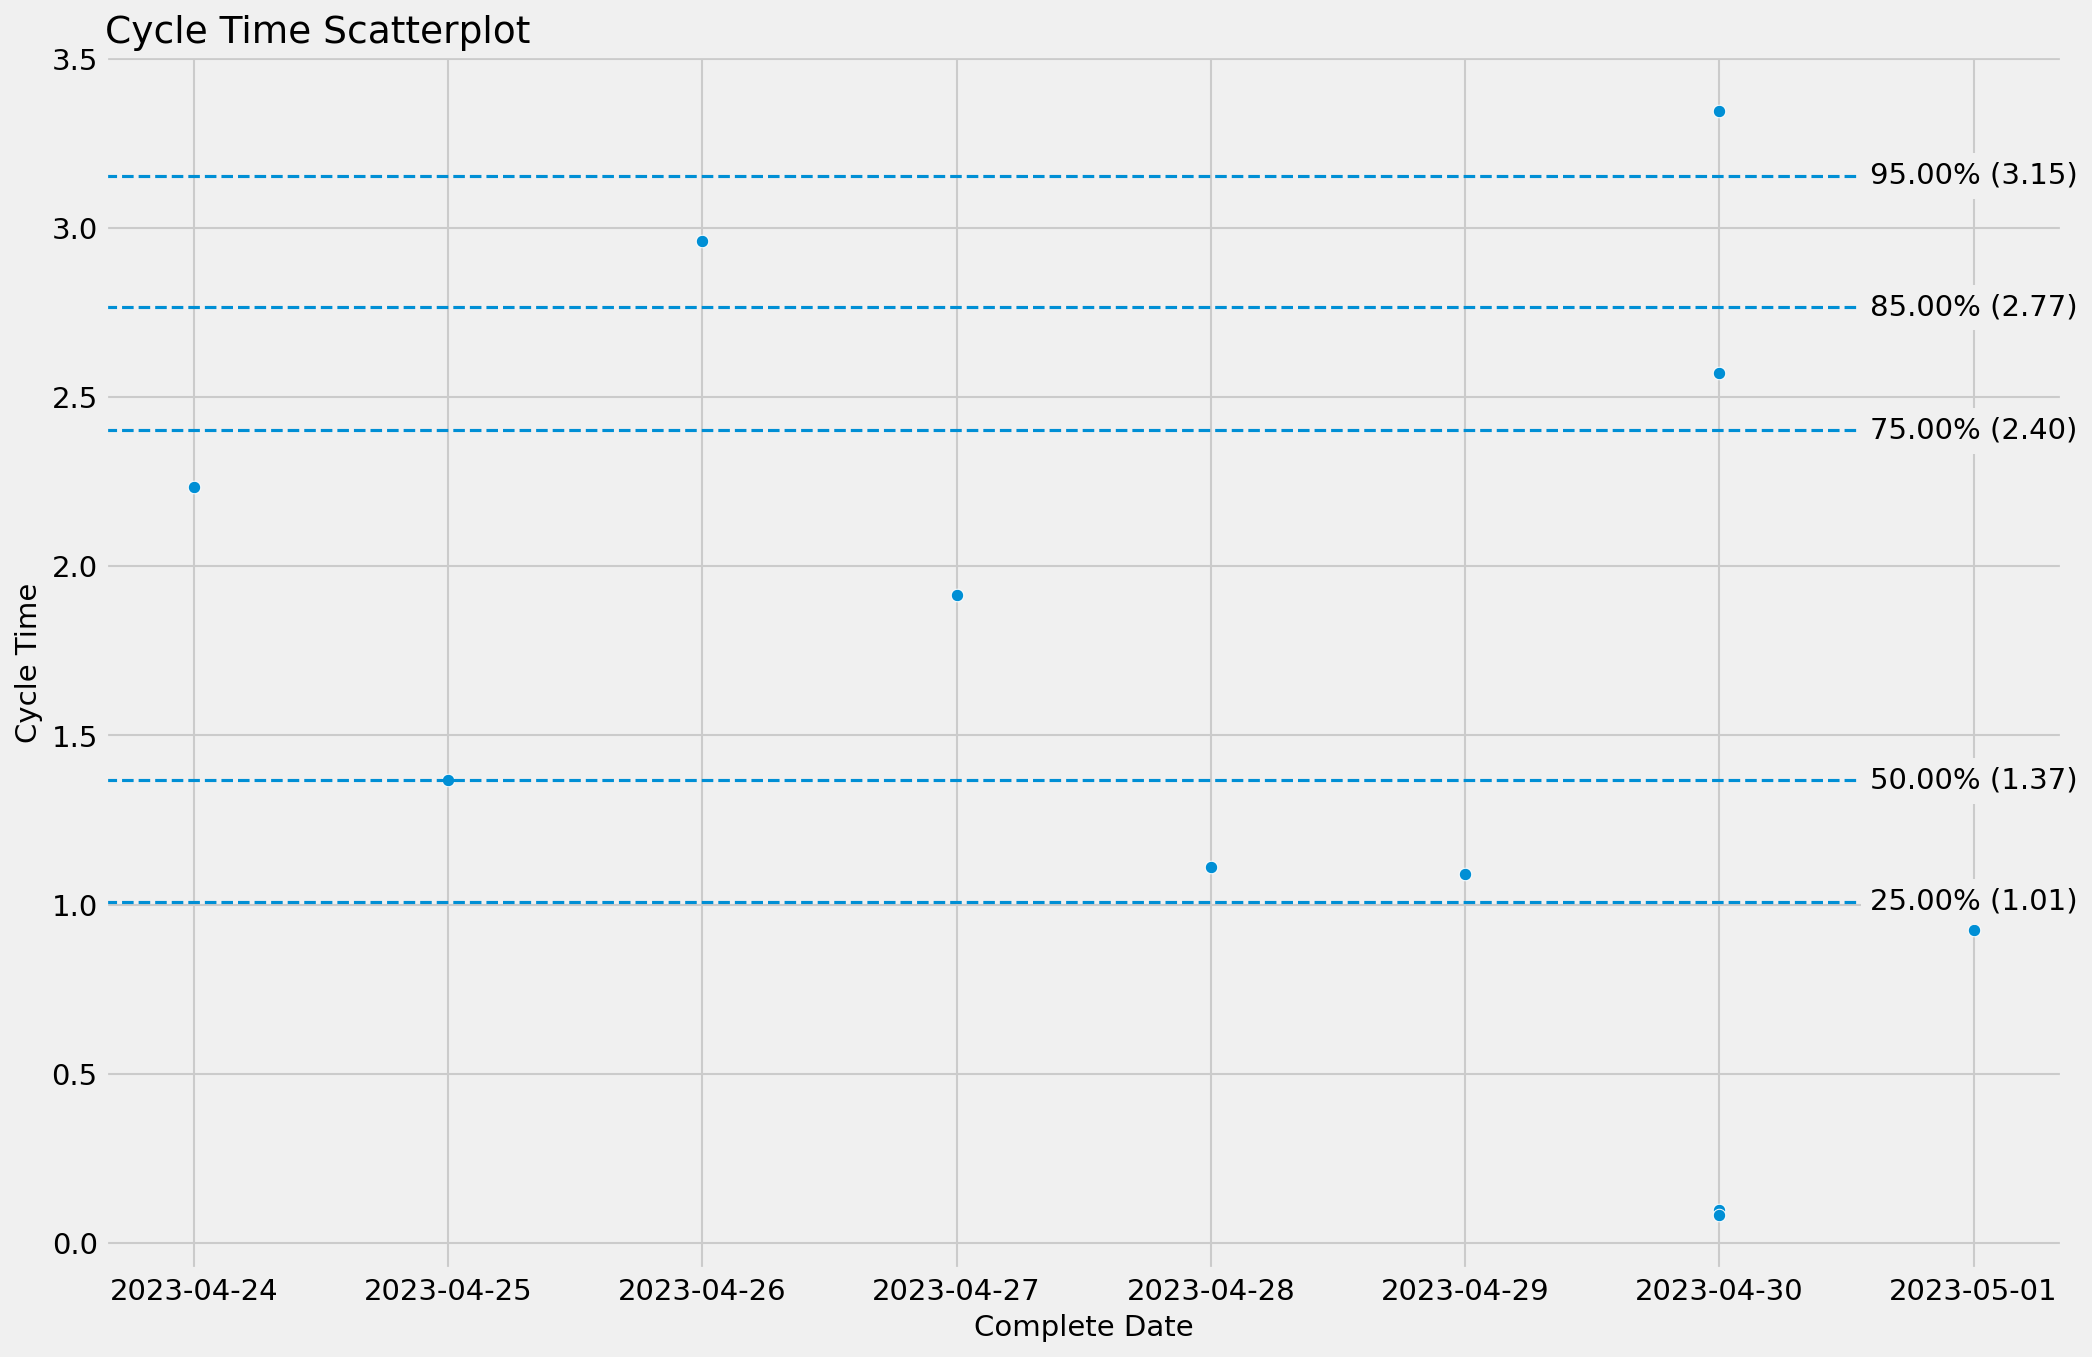

In [17]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

x, y = cycle_data['Complete Date'], cycle_data['Cycle Time']

ax = seaborn.scatterplot(x=x, y=y)
ax.set_title("Cycle Time Scatterplot",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

for v in (0.25, 0.5, 0.75, 0.85, 0.95):
    ax.axhline(y=y.quantile(v),  linestyle='--')
    ax.text(x=x.max(),
            y=y.quantile(v),
            va='center',
            ha='center',
            backgroundcolor='#F0F0F0',
            s='%.2f%% (%.2f)' % (v*100, y.quantile(v)))

In [25]:
cycle_data.head(1)

,Work Item,In Progress Date,Complete Date,Cycle Time,Moving Average (10 items),Moving Standard Deviation (10 items),Average,Standard Deviation
0,SKP-16,2023-04-22,2023-04-24,2.233333,NaN,NaN,1.609297,1.092165


In [64]:
import plotly.graph_objects as go

x, y = cycle_data['Complete Date'], cycle_data['Cycle Time']
issue_key = cycle_data['Work Item']

f = go.FigureWidget([go.Scatter(x=x,
                                y=y,
                                text = issue_key,
                                mode='markers',
                                hovertemplate='Issue Key: %{text}<br>Cycle Time: %{y:.2f}<extra></extra>'
                               )])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'x'

# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s
            scatter.marker.text = 'Test'


scatter.on_click(update_point)

f


FigureWidget({
    'data': [{'hovertemplate': 'Issue Key: %{text}<br>Cycle Time: %{y:.2f}<extra></extra>',
              'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
                                   #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
             

In [18]:
ax.figure.savefig('images/cycletime-scatterplot.png')

### Throughput

In [19]:
throughput, throughput_per_week = analysis.process_throughput_data(issue_data,
                                                                   since=FILTER_ISSUES_SINCE,
                                                                   until=FILTER_ISSUES_UNTIL)
throughput_per_week.head(1)

,Throughput,Moving Average (4 weeks),Moving Standard Deviation (4 weeks),Average,Standard Deviation
Date,,,,,
2023-04-17,0,NaN,NaN,3.666667,5.507571


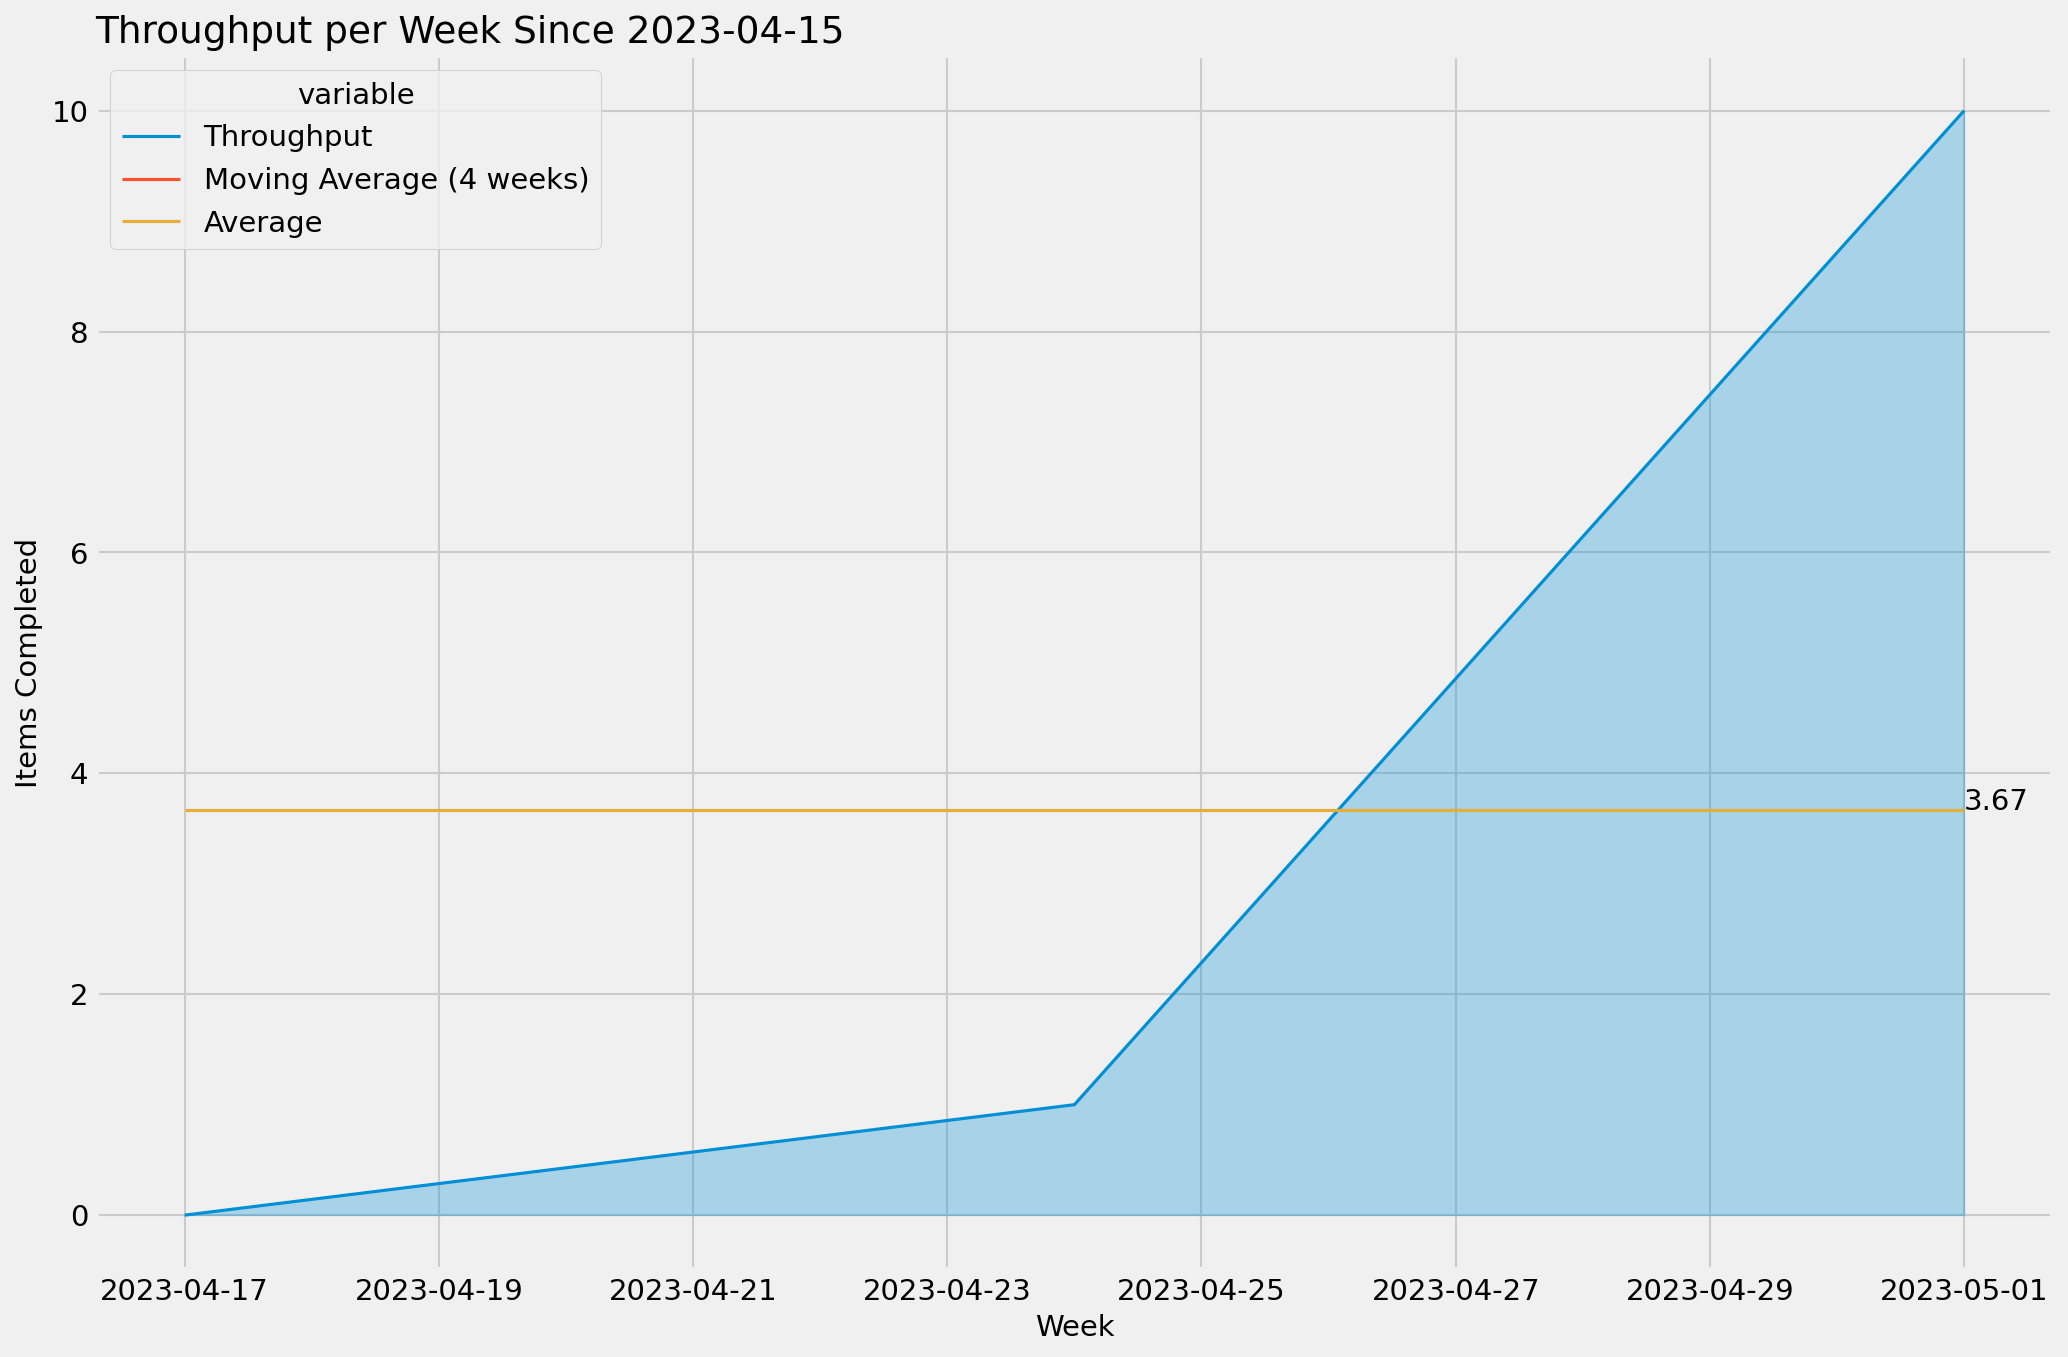

In [20]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

throughput_per_week = throughput_per_week.reset_index()

ax = seaborn.lineplot(x='Date',
                      y='value',
                      hue='variable',
                      data=pandas.melt(throughput_per_week[['Date',
                                                            'Throughput',
                                                            'Moving Average (4 weeks)',
                                                            'Average']],
                                       ['Date']))

x = throughput_per_week['Date']
y1 = throughput_per_week['Throughput']
ax.fill_between(x, y1, color='C0', alpha=0.3,
                 interpolate=True)

ax.set_title(f"Throughput per Week Since {FILTER_ISSUES_SINCE}",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

ax.set_xlabel('Week')
ax.set_ylabel('Items Completed')

_ = ax.text(throughput_per_week['Date'].max(),
            throughput_per_week['Average'].max(),
            "{:.2f}".format(throughput_per_week['Average'].max()))

In [21]:
ax.figure.savefig('images/throughput-timeline.png')

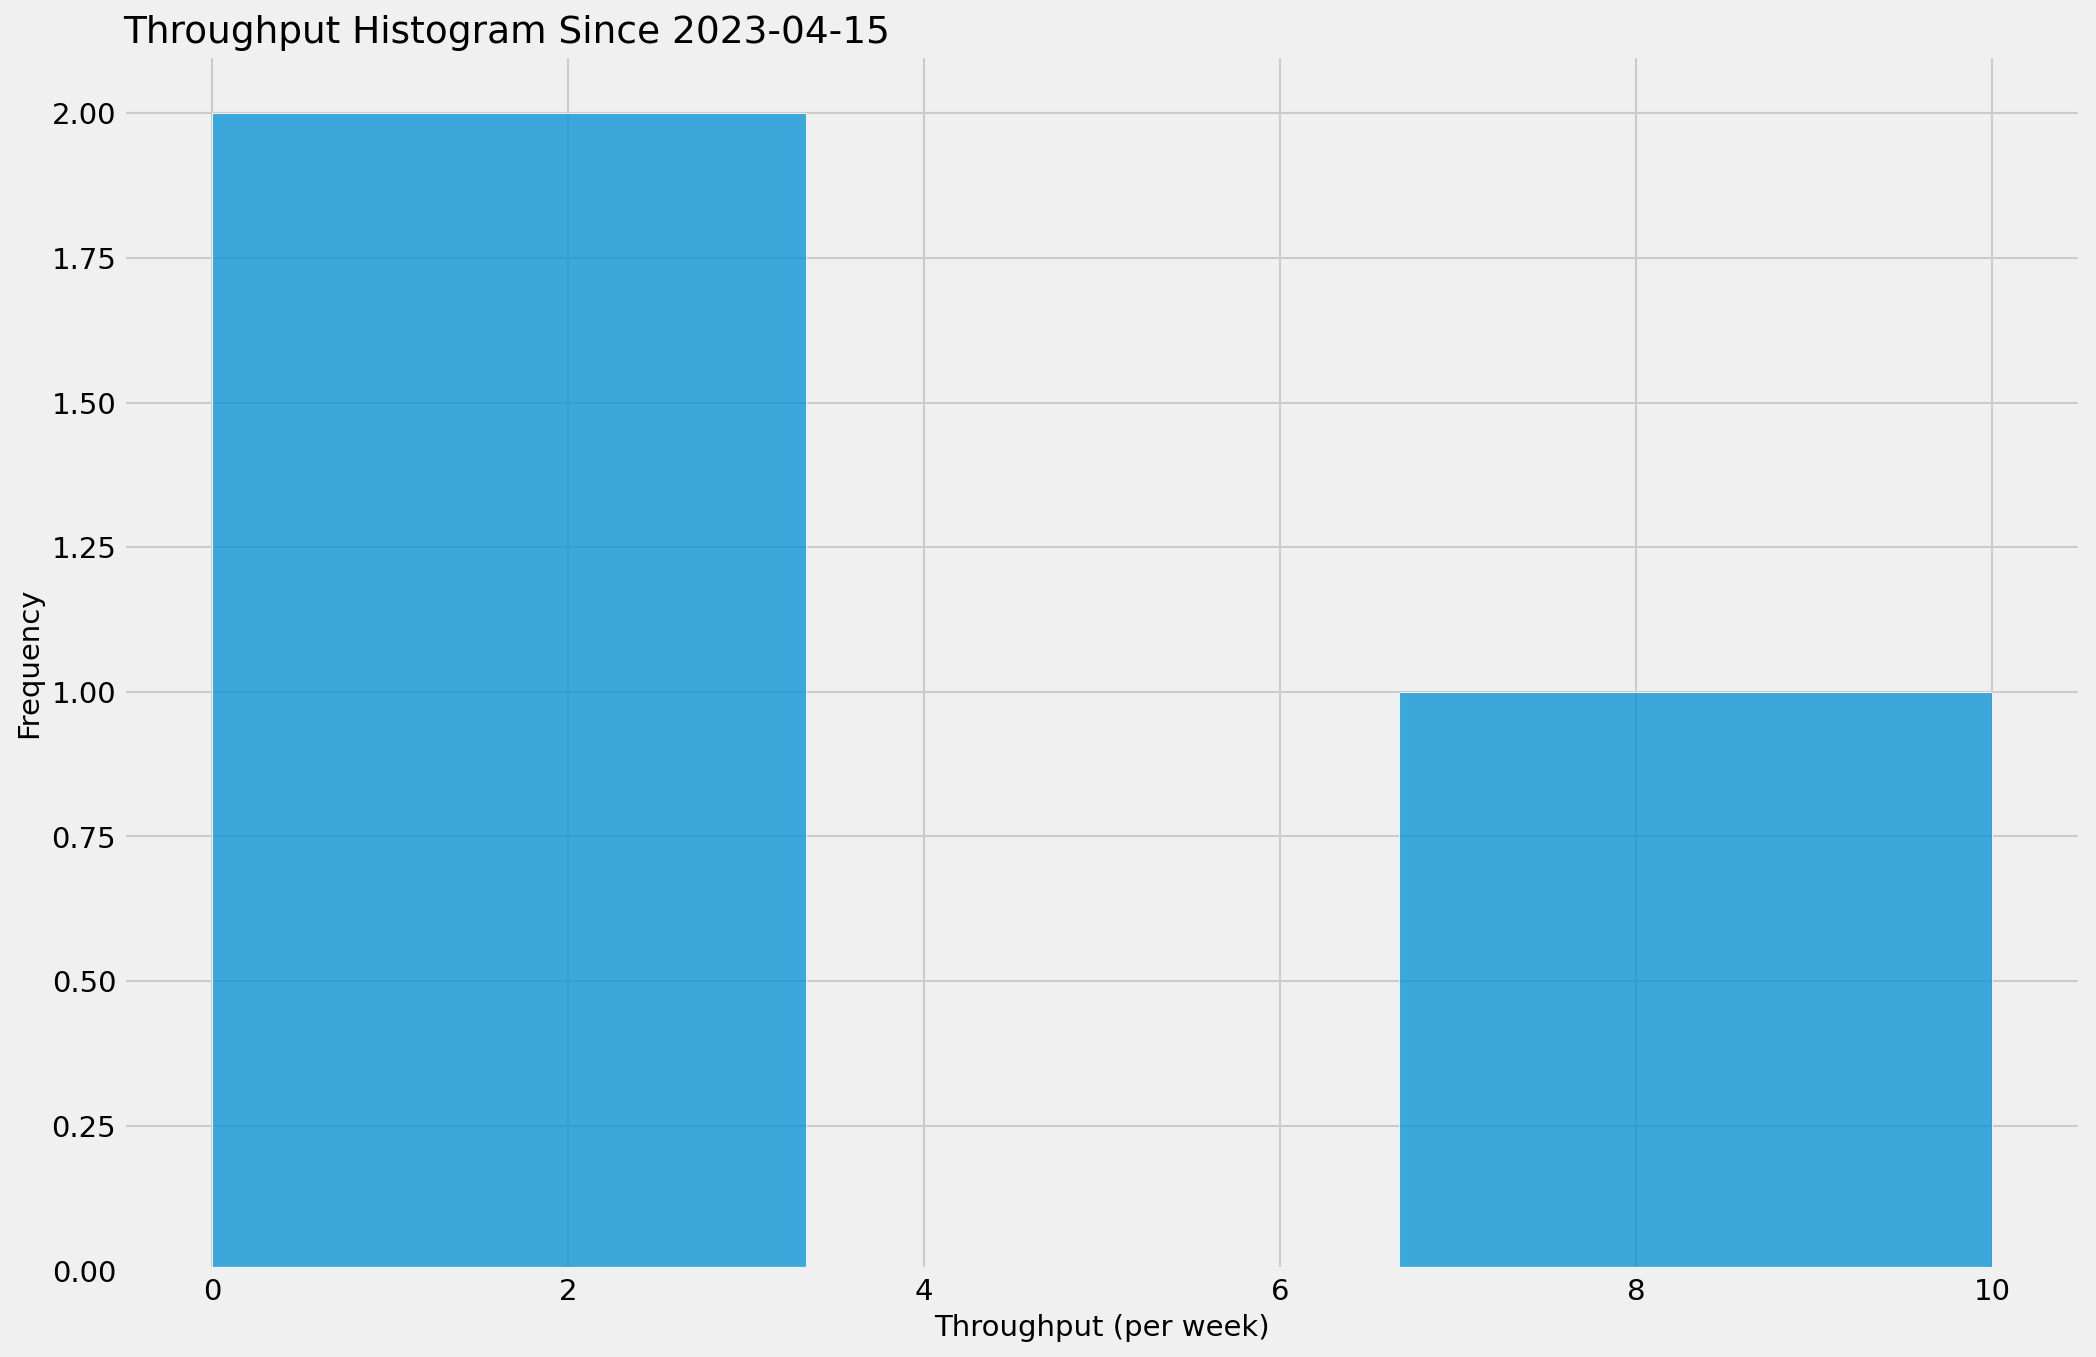

In [22]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.histplot(throughput_per_week['Throughput'], kde=False)

ax.set_title(f"Throughput Histogram Since {FILTER_ISSUES_SINCE}",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})
ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Throughput (per week)')

In [23]:
ax.figure.savefig('images/throughput-histogram.png')

### Cumulative Flow Diagram

In [24]:
f = analysis.process_flow_category_data(data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
f.tail(1)

,In Progress,Done,To Do
Date,,,
2023-05-01,11,11,4


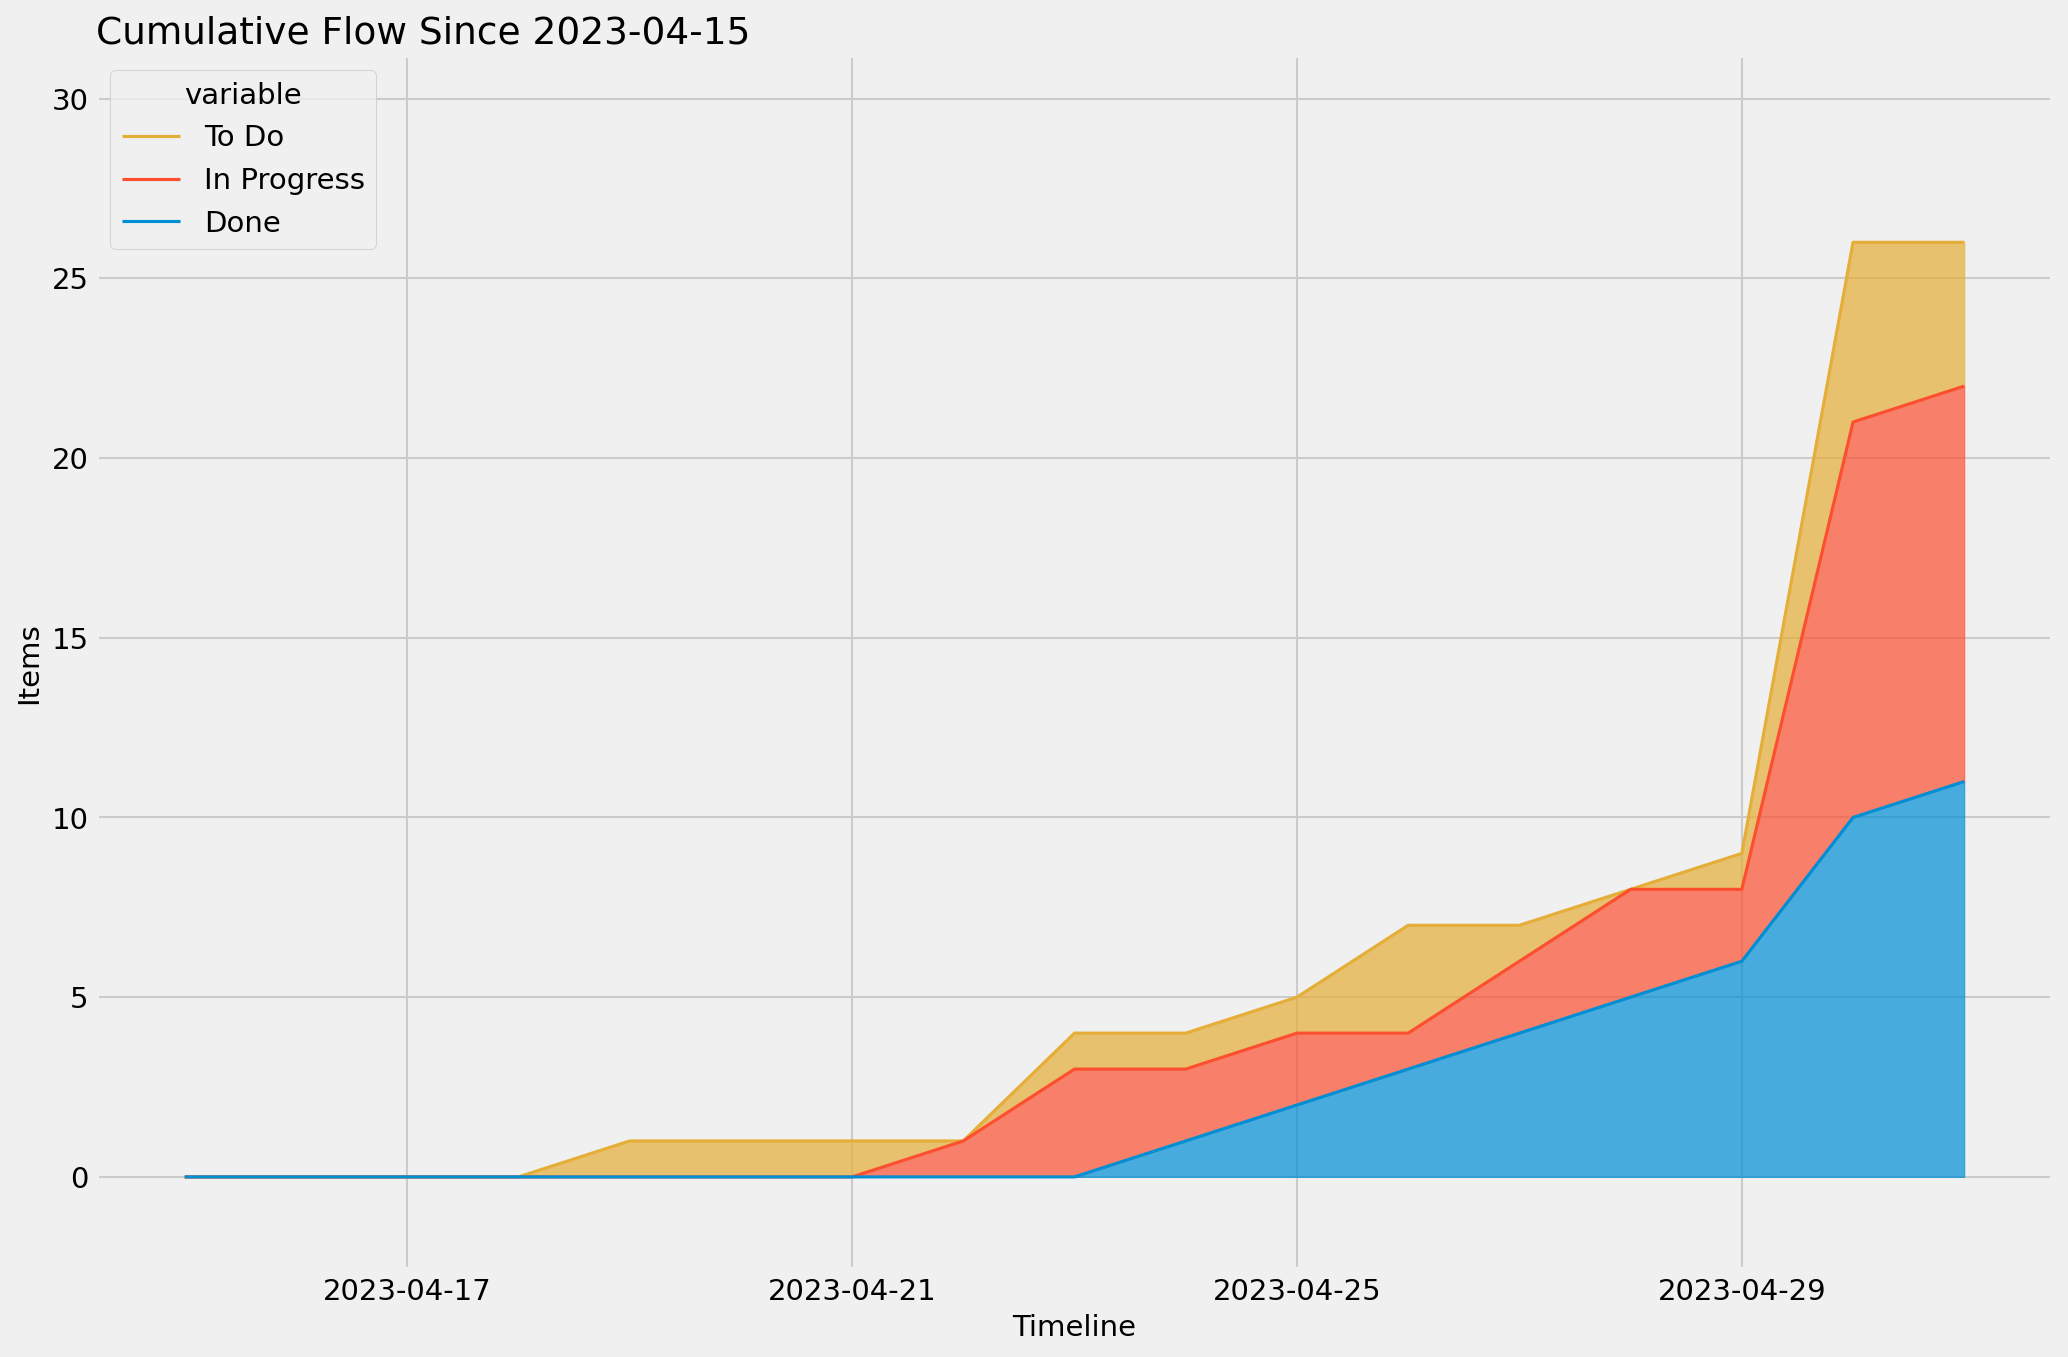

In [25]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
ax = analysis.plot_flow(f, status_columns=('Done', 'In Progress', 'To Do'))

In [26]:
ax.figure.savefig('images/flow-category-timeline.png')

In [27]:
f = analysis.process_flow_data(data,
                               since=FILTER_ISSUES_SINCE,
                               until=FILTER_ISSUES_UNTIL)
f.tail(1)

,In Progress,In Review,Backlog,Done,Selected for Development
Date,,,,,
2023-05-01,7,4,0,11,7


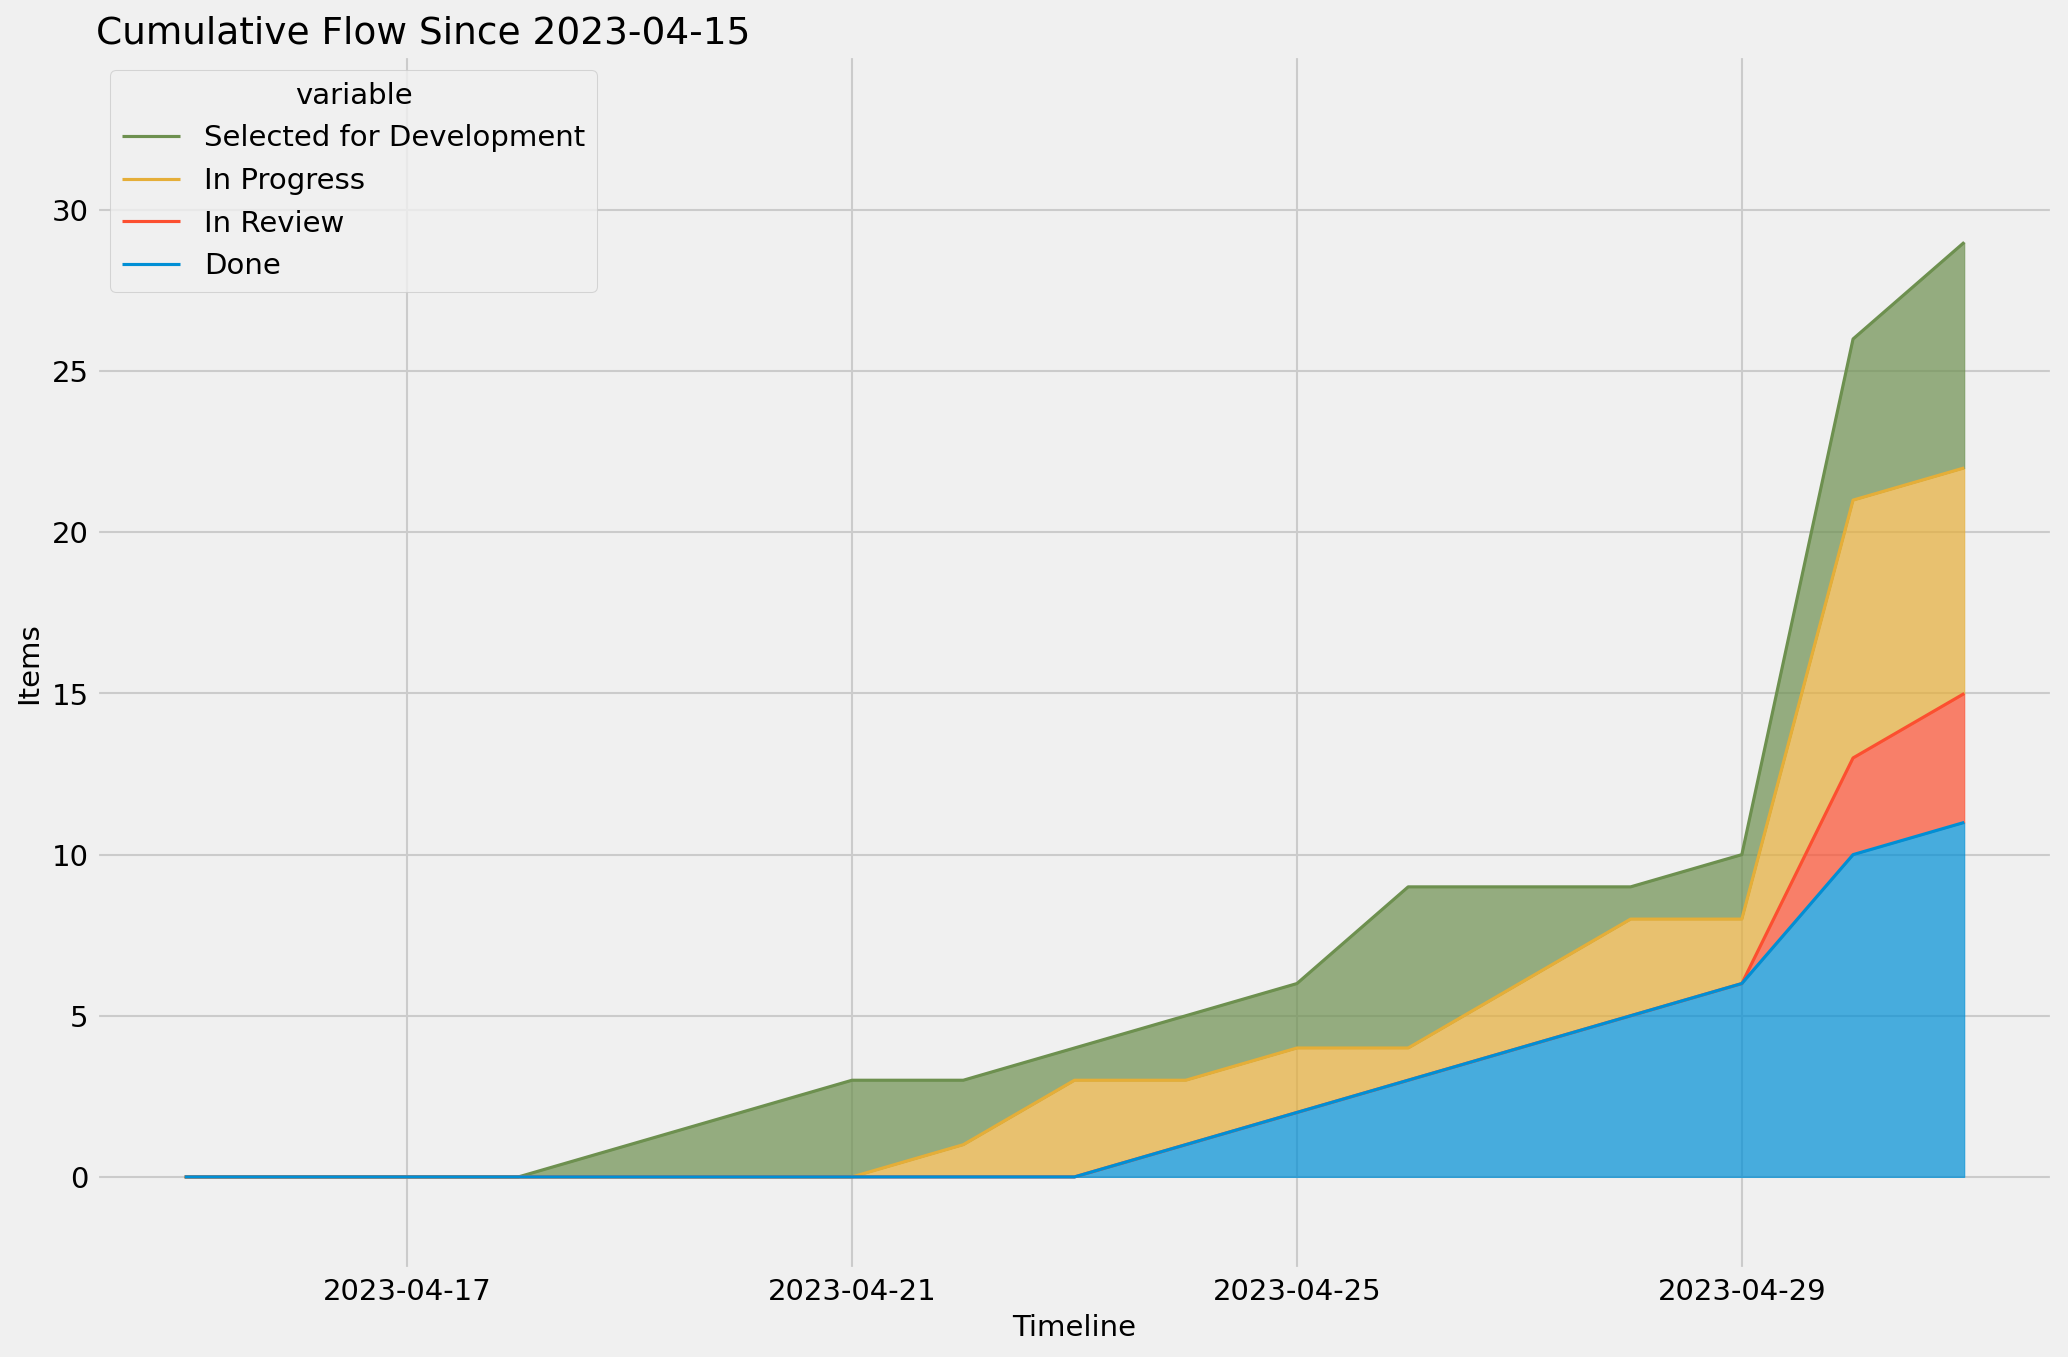

In [28]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
status_columns = list(s for s in reversed(STATUS_ORDER) if s in f)
if status_columns: ax = analysis.plot_flow(f, status_columns=status_columns)

In [29]:
if status_columns: ax.figure.savefig('images/flow-timeline.png')

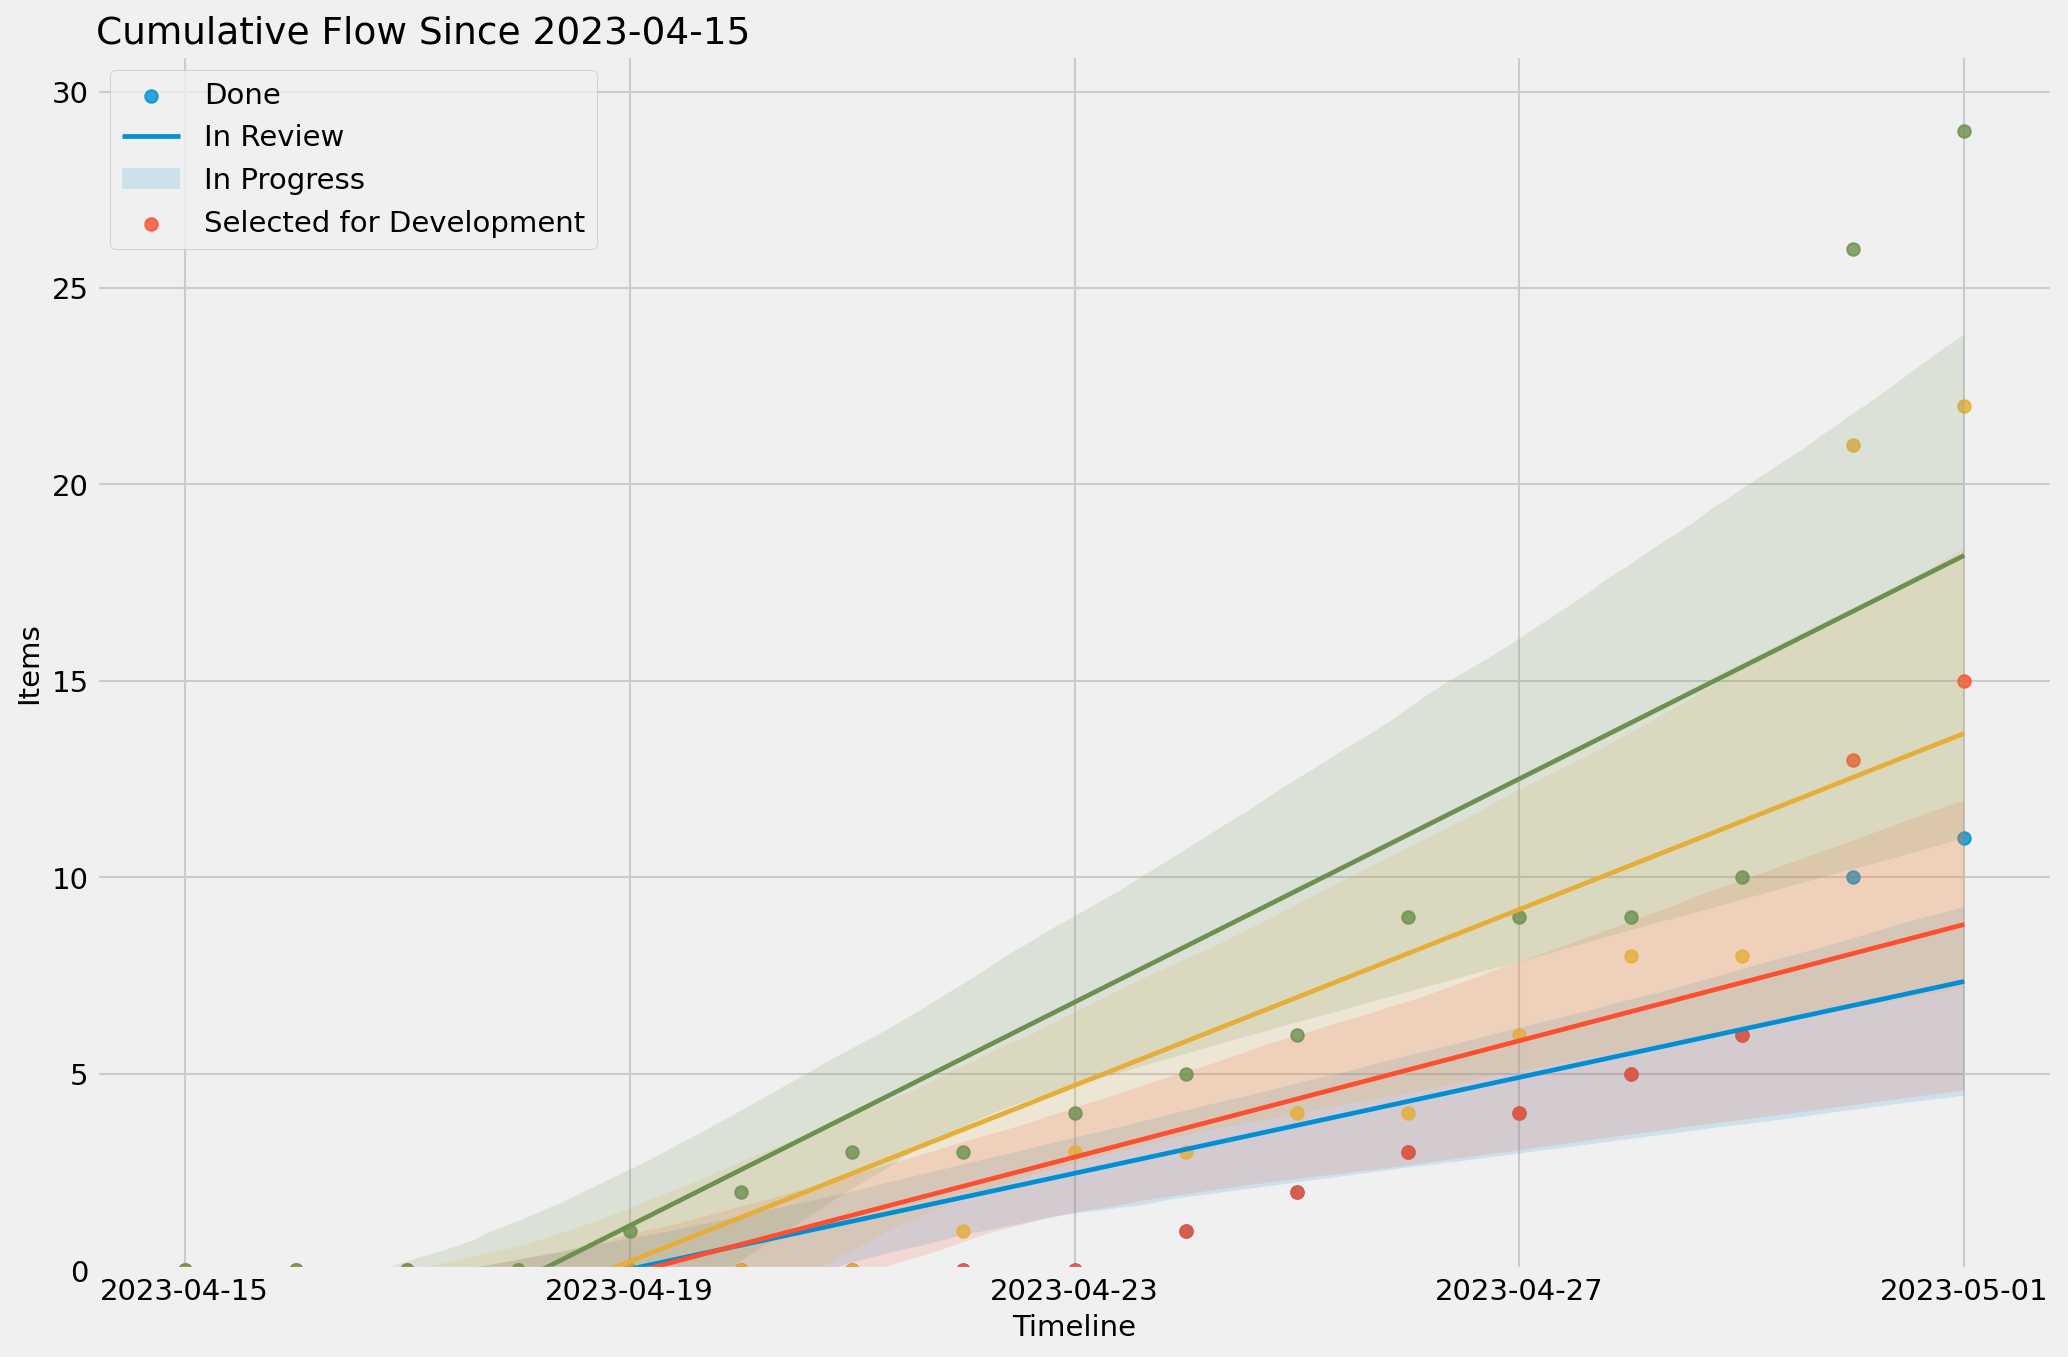

In [30]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
status_columns = list(s for s in reversed(STATUS_ORDER) if s in f)
if status_columns: ax = analysis.plot_flow_trendlines(f, status_columns=status_columns)

In [31]:
if STATUS_ORDER: ax.figure.savefig('images/flow-timeline-trend.png')

### Work In Progress

In [32]:
wip, _ = analysis.process_wip_data(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
wip.tail(1)

,Work In Progress,Moving Average (10 days),Moving Standard Deviation (10 days),Average,Standard Deviation
Date,,,,,
2023-05-01,6,2.8,1.813529,1.647059,1.966633


Text(0, 0.5, 'Items')

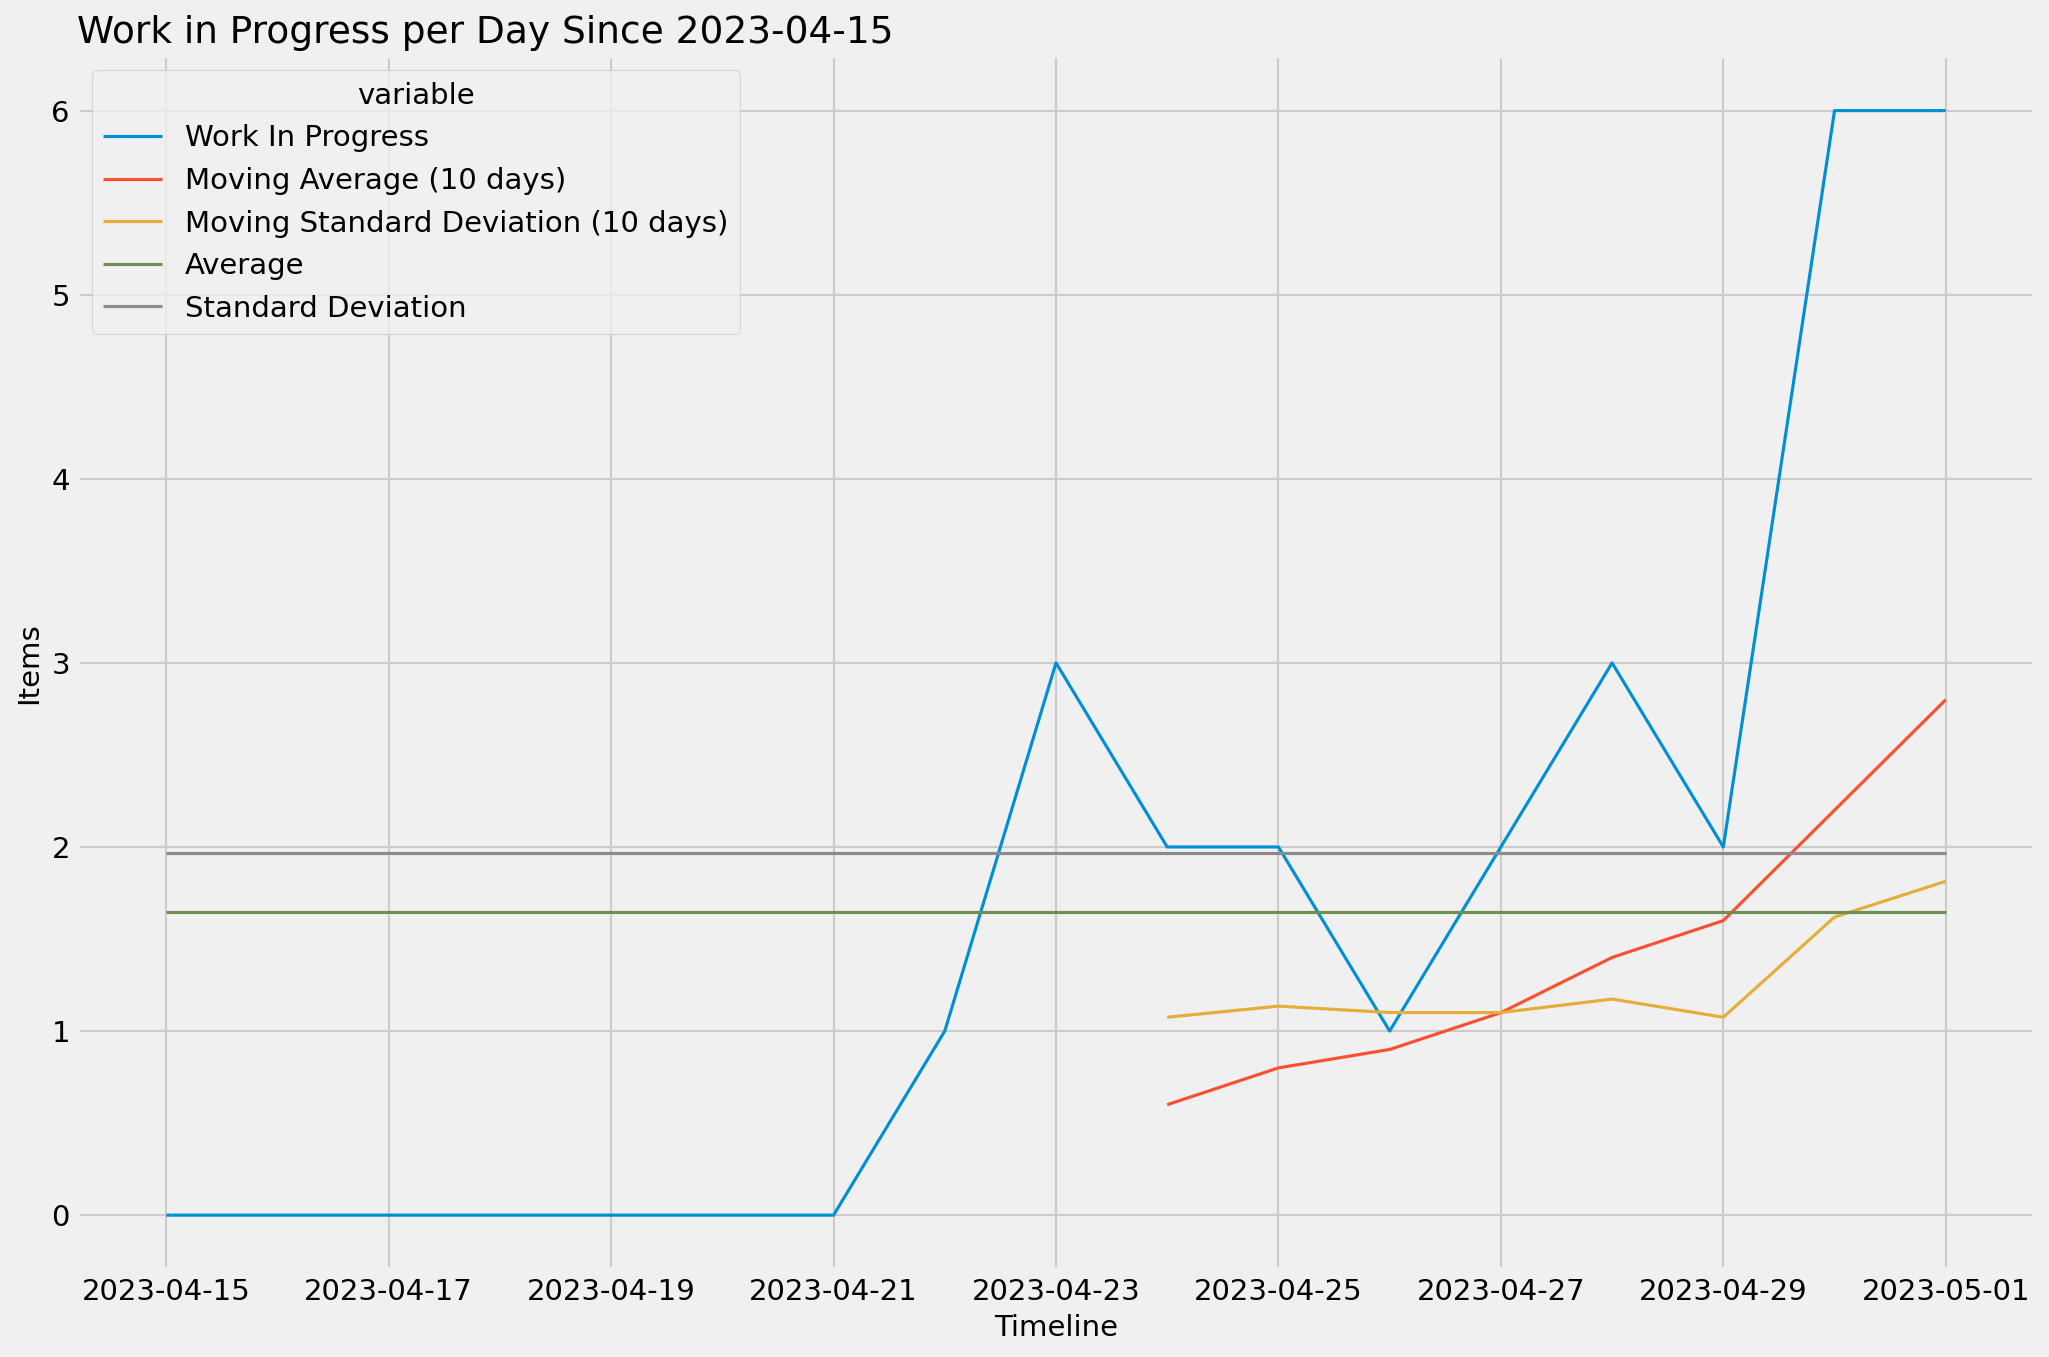

In [33]:
wip = wip.reset_index()
wip_melted = pandas.melt(wip, ['Date'])
wip_melted['value'] = wip_melted['value'].astype(float)

matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='Date', y='value', hue='variable', data=wip_melted)

ax.set_title(f"Work in Progress per Day Since {wip['Date'].min().strftime('%Y-%m-%d')}",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Items')

In [34]:
ax.figure.savefig('images/wip-timeline.png')

In [35]:
age_data = analysis.process_wip_age_data(issue_data,
                                         since=FILTER_ISSUES_SINCE,
                                         until=FILTER_ISSUES_UNTIL)

Text(0, 0.5, 'Days')

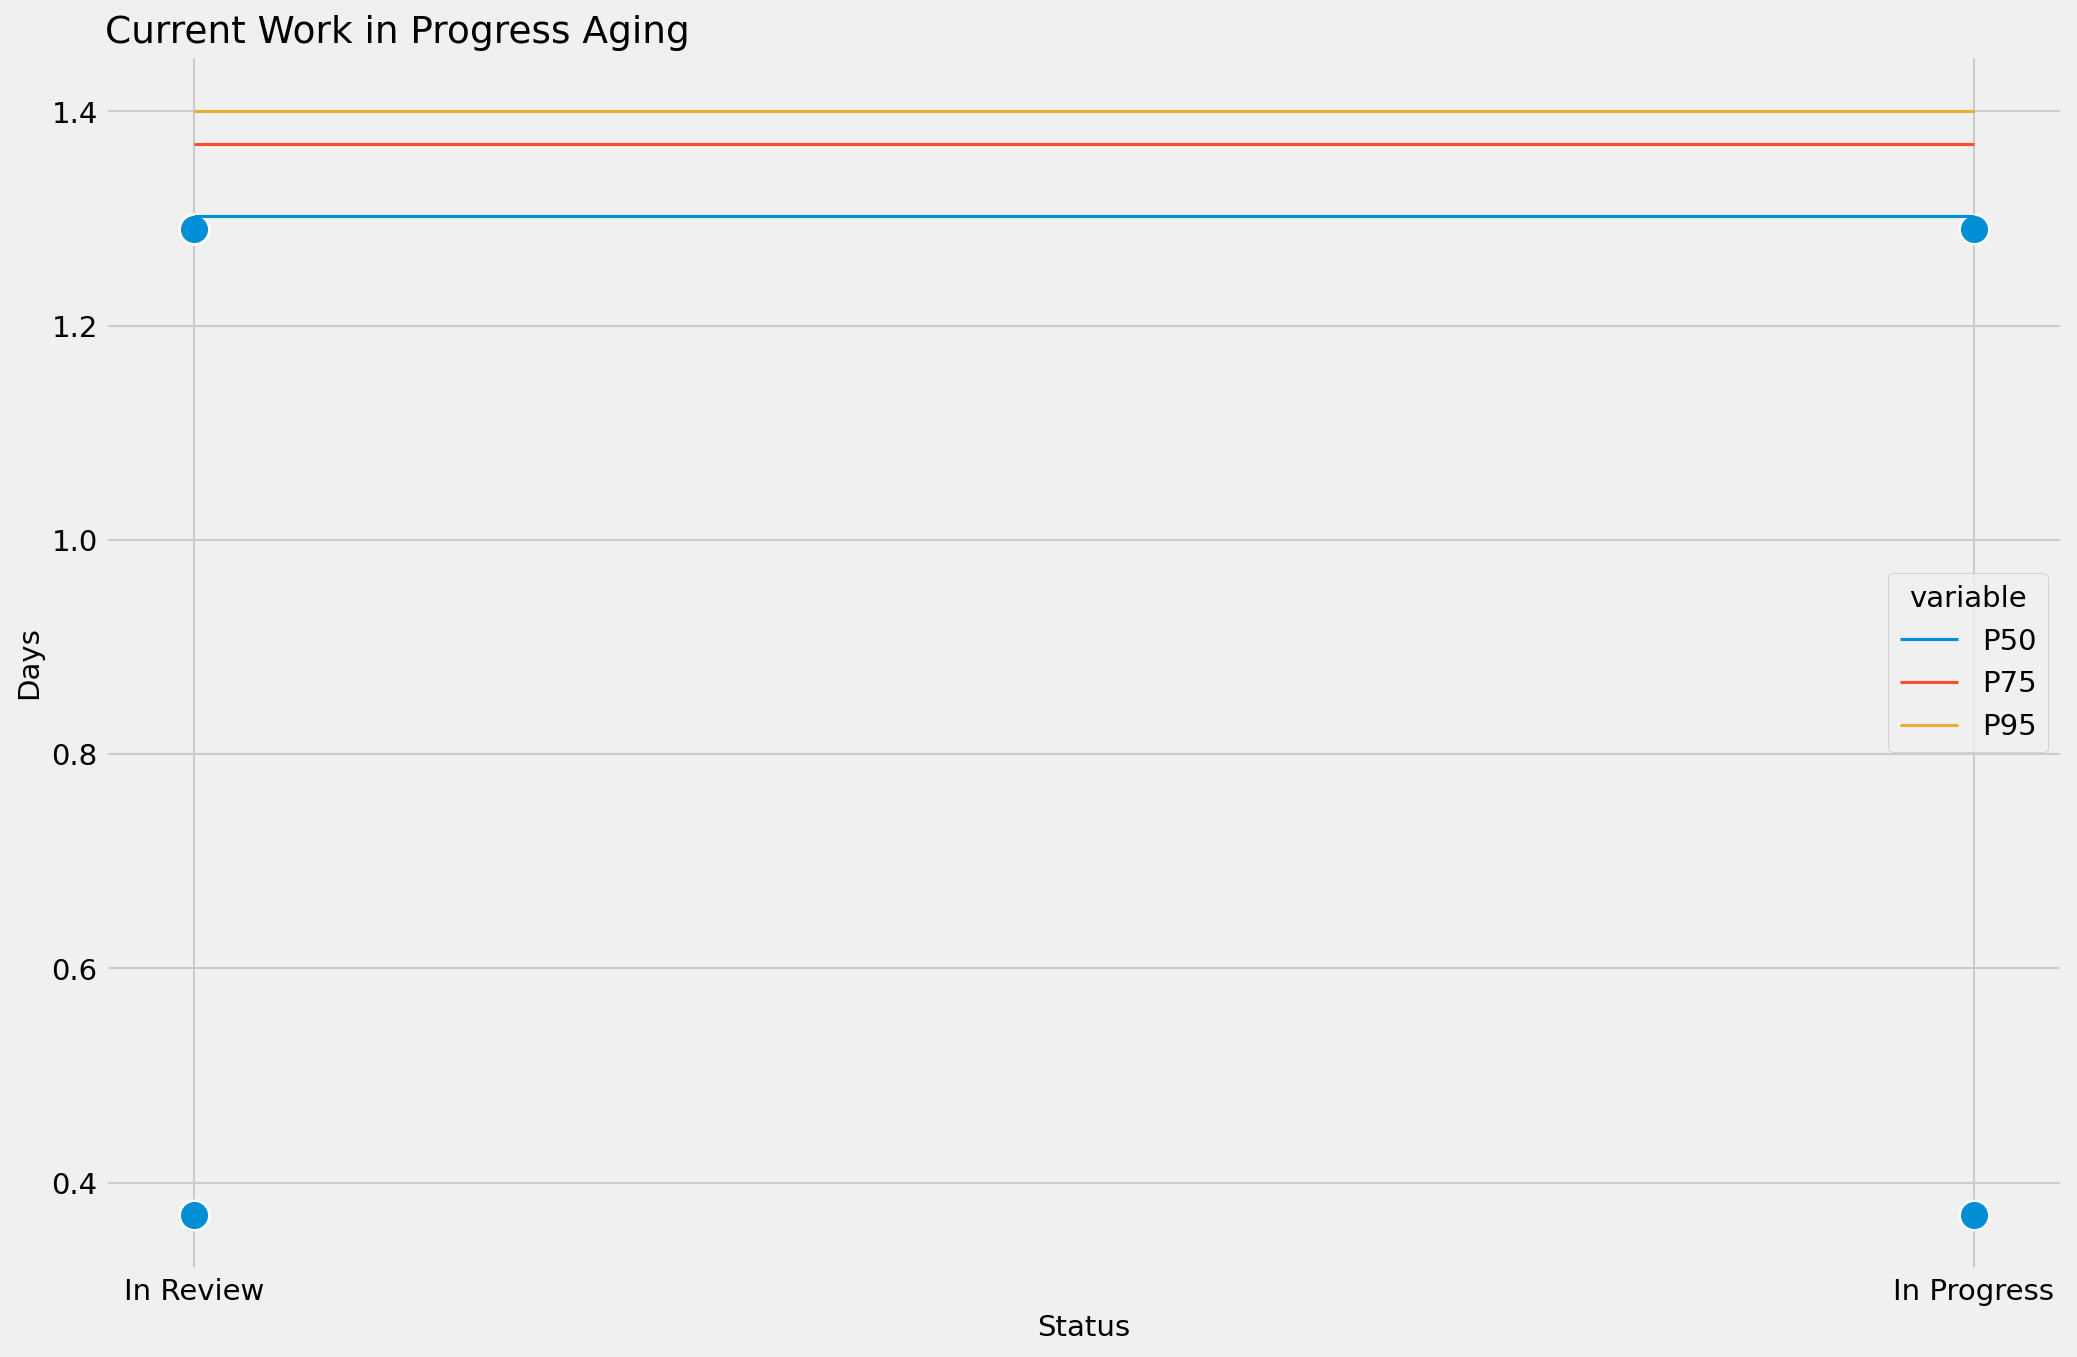

In [36]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.scatterplot(x='last_issue_status',
                         y='Age in Stage',
                         data=age_data,
                         s=200,
                         sizes=(200, 200))

ax = seaborn.lineplot(x='last_issue_status',
                      y='value',
                      hue='variable',
                      dashes=True,
                      data=pandas.melt(age_data[['last_issue_status', 'P50', 'P75', 'P95']],
                                       ['last_issue_status']),
                      ax=ax)

ax.set_title("Current Work in Progress Aging",
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})

ax.set_xlabel('Status')
ax.set_ylabel('Days')

In [37]:
ax.figure.savefig('images/wip-aging.png')

## Forecasting

### Kaplan-Meier Surviability

In [38]:
model, km = analysis.analyze_survival_km(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)

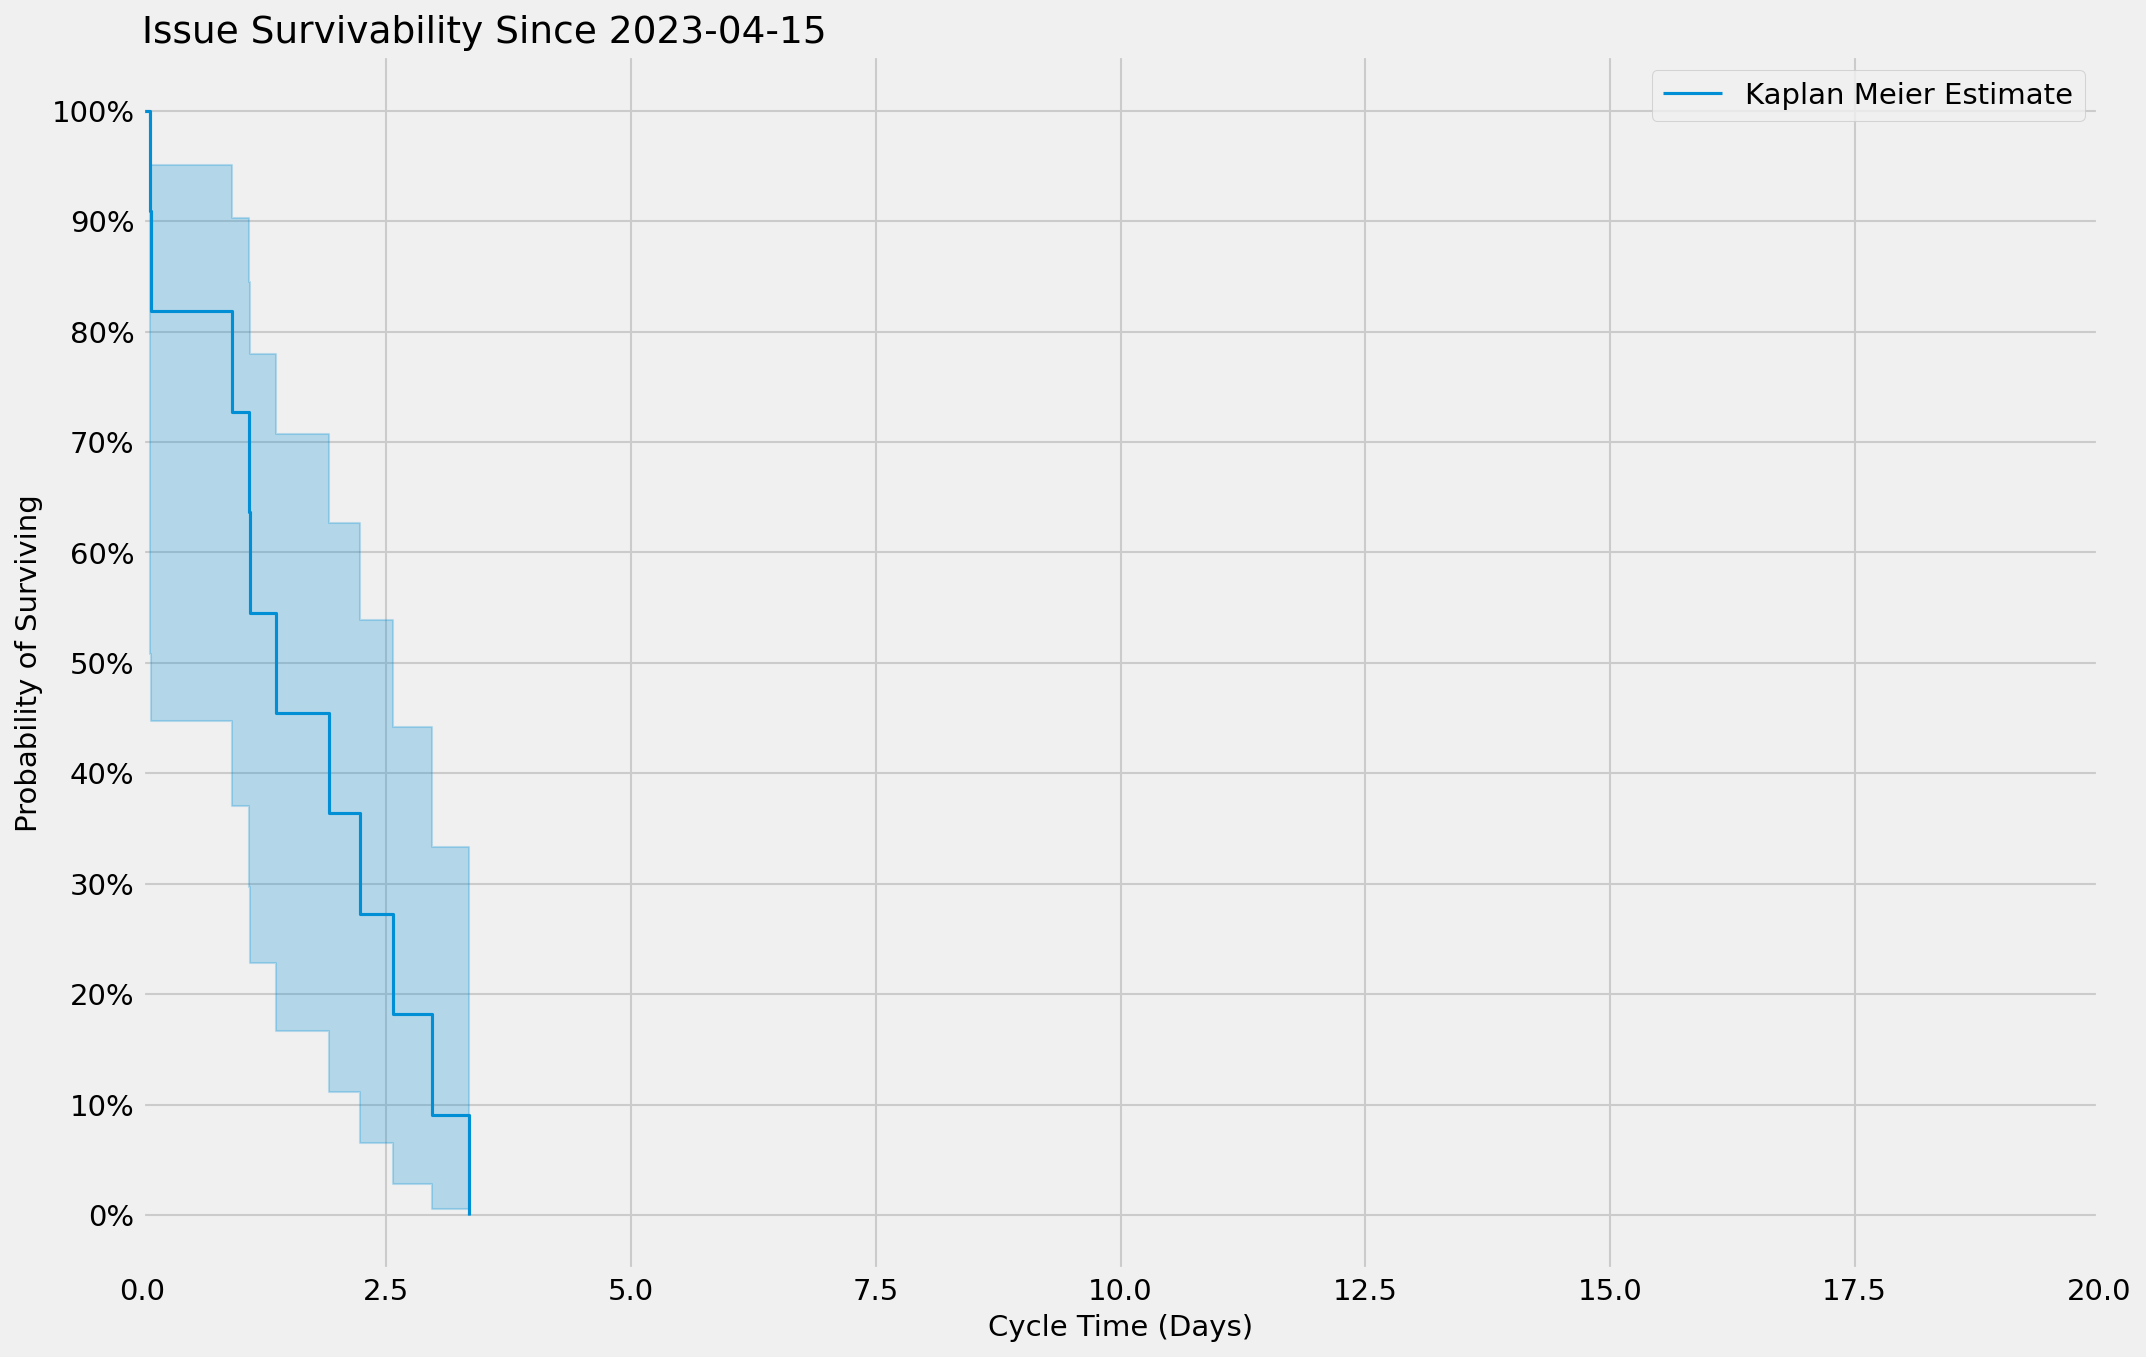

In [39]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = km.plot()

ax.set_title(f'Issue Survivability Since {FILTER_ISSUES_SINCE}',
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})
ax.set_yticks([i/100.0 for i in range(0,110,10)])
def format_func(value, tick_number):
    return f'{int(value*100)}%'
ax.set_xlim([0, 20])
ax.yaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))
ax.set_ylabel('Probability of Surviving')
_ = ax.set_xlabel('Cycle Time (Days)')

In [40]:
ax.figure.savefig('images/forecast-kaplan-meier.png')

### Weibull Analysis

In [41]:
model, wb = analysis.analyze_survival_wb(issue_data,
                                         since=FILTER_ISSUES_SINCE,
                                         until=FILTER_ISSUES_UNTIL)

Text(0.5, 0, 'Cycle Time (Days)')

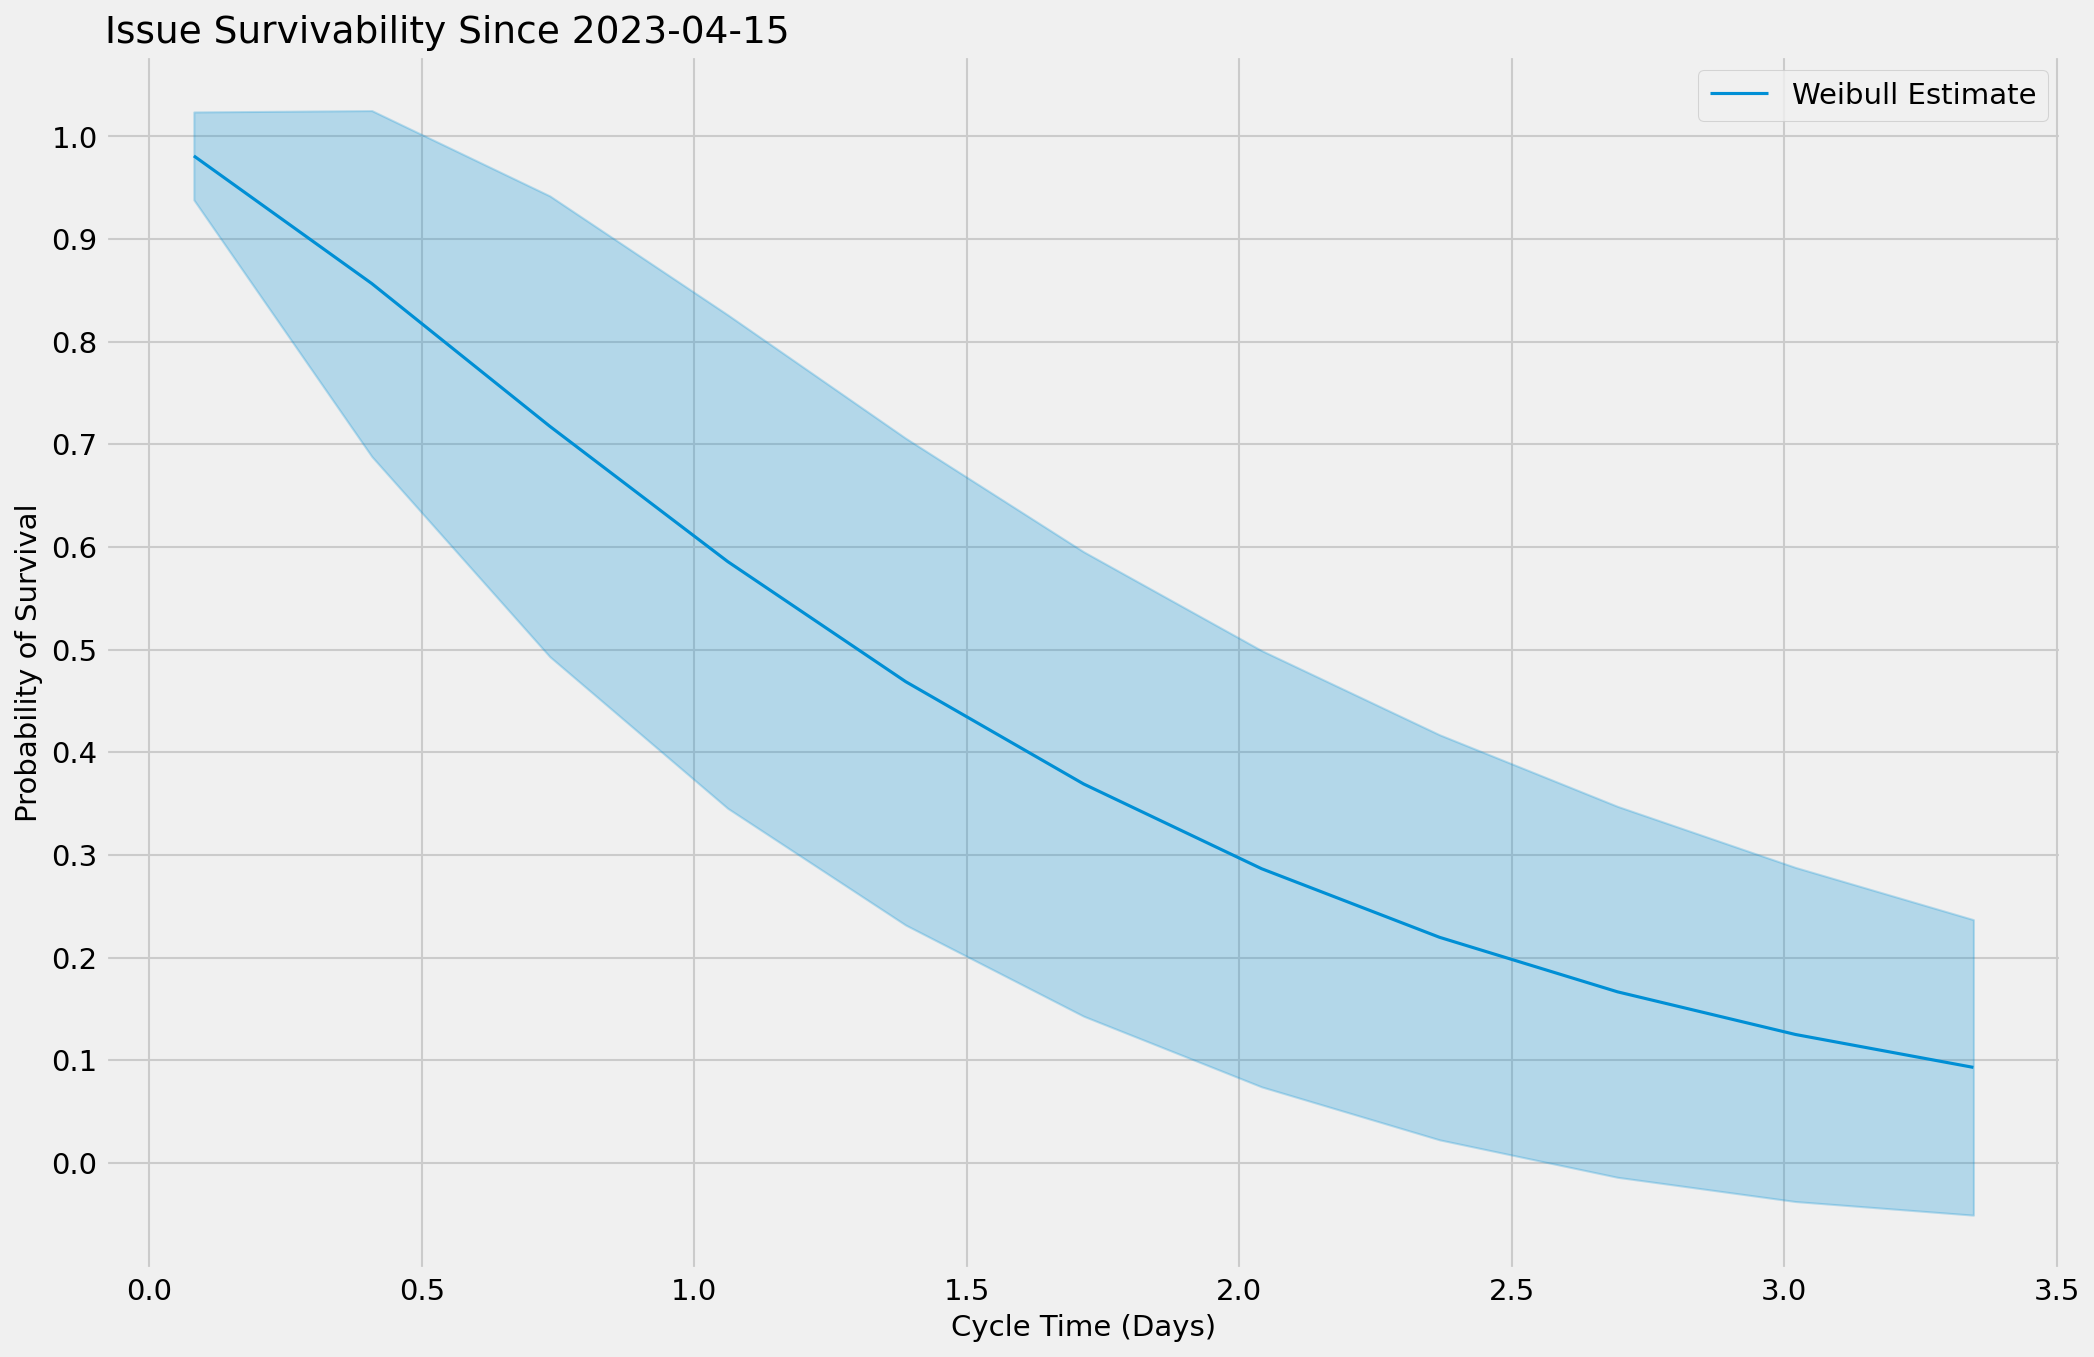

In [42]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = wb.plot_survival_function()
ax.set_yticks([i/100.0 for i in range(0,110,10)])
ax.set_title(f'Issue Survivability Since {FILTER_ISSUES_SINCE}',
             loc='left',
             fontdict={'fontsize': 18,
                       'fontweight': 'normal'})
ax.set_ylabel('Probability of Survival')
ax.set_xlabel('Cycle Time (Days)')

In [43]:
ax.figure.savefig('images/forecast-weibull-survival.png')

### Monte-Carlo Simulation

#### [WHEN]: By what date will N number of items be completed?

In [44]:
SIMULATION_ITEMS = 10 #N
SIMULATIONS = 100
LAST_DAYS = 15

In [45]:
distribution_when, samples = analysis.forecast_montecarlo_how_long_items(throughput,
                                                                         items=SIMULATION_ITEMS,
                                                                         simulations=SIMULATIONS,
                                                                         window=LAST_DAYS)

Text(0, 0.5, 'Frequency')

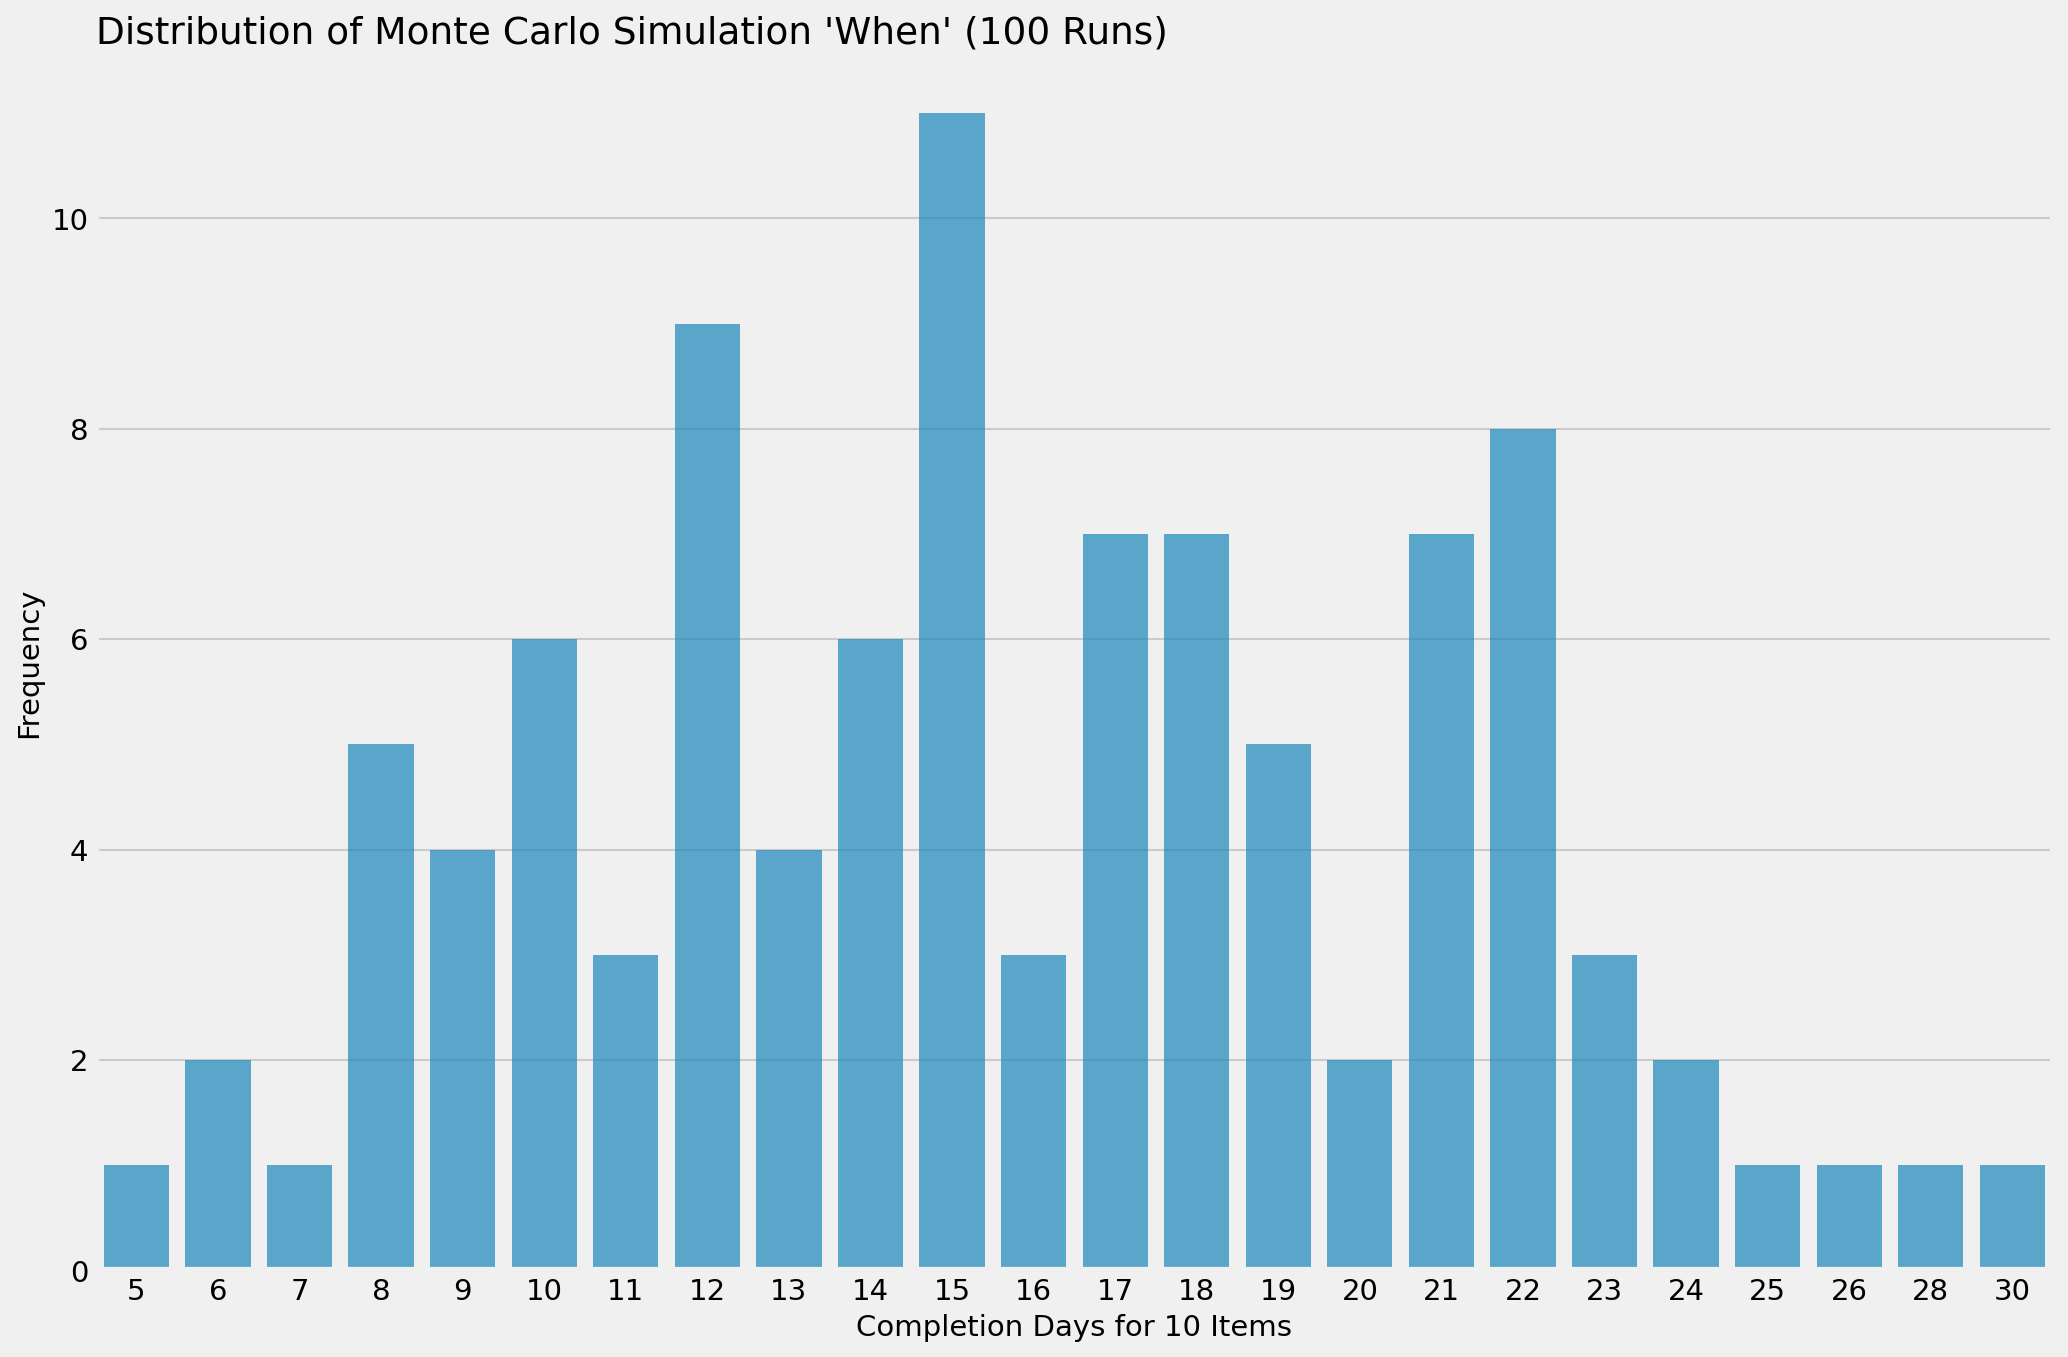

In [46]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Days', y='Frequency', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'normal'})

ax.set_xlabel(f"Completion Days for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')

In [47]:
ax.figure.savefig('images/distribution-montecarlo-when.png')

[Text(0, 0, '0%'),
 Text(0, 20, '20%'),
 Text(0, 40, '40%'),
 Text(0, 60, '60%'),
 Text(0, 80, '80%'),
 Text(0, 100, '100%')]

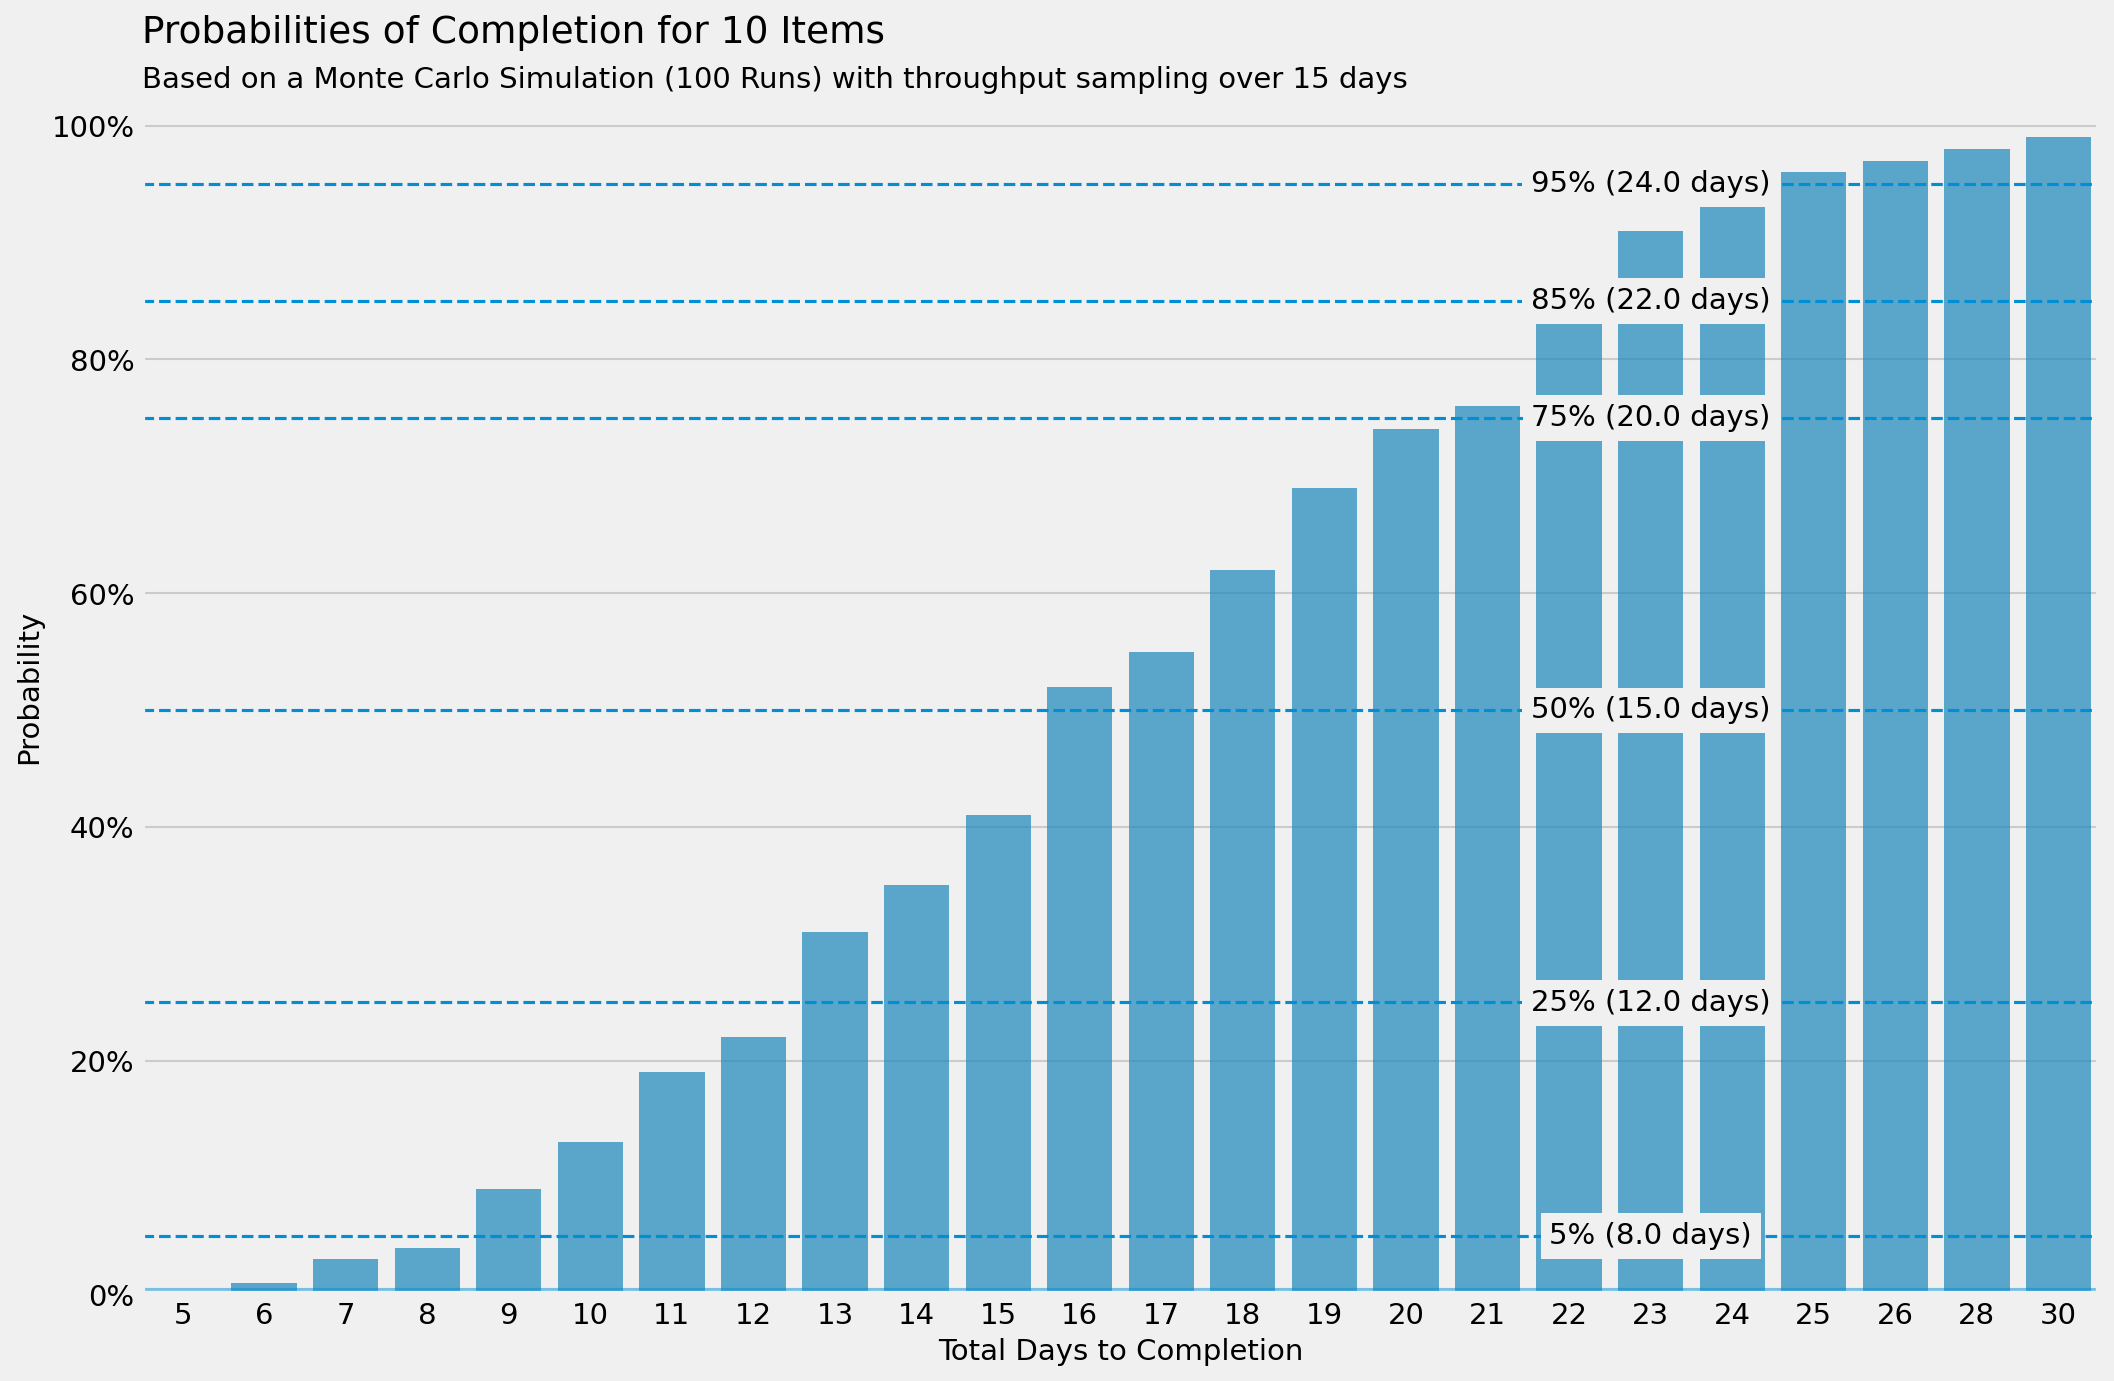

In [48]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Days', y='Probability', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Probabilities of Completion for {SIMULATION_ITEMS} Items", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})

ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Days to Completion')
ax.axhline(y=0.5, alpha=.5)
ax.axhline(y=5,   linestyle='--')
ax.axhline(y=25,  linestyle='--')
ax.axhline(y=50,  linestyle='--')
ax.axhline(y=75,  linestyle='--')
ax.axhline(y=85,  linestyle='--')
ax.axhline(y=95,  linestyle='--')

unique_dates = sorted(list(distribution_when['Days'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)

xpos = 0.75 * len(unique_dates)

ax.text(y=5, x=xpos, s=f"5% ({(samples.Days.quantile(0.05))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=xpos, s=f"25% ({(samples.Days.quantile(0.25))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=xpos, s=f"50% ({(samples.Days.quantile(0.5))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=75, x=xpos, s=f"75% ({(samples.Days.quantile(0.75))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=xpos, s=f"85% ({(samples.Days.quantile(0.85))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=xpos, s=f"95% ({(samples.Days.quantile(0.95))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%'])

In [49]:
ax.figure.savefig('images/forecast-montecarlo-when.png')

#### [HOW MANY]: How many items will be completed in the next N days?

In [50]:
SIMULATION_DAYS = 20 #N
SIMULATIONS = 100
LAST_DAYS = 15

In [51]:
distribution_how, samples = analysis.forecast_montecarlo_how_many_items(throughput,
                                                                        days=SIMULATION_DAYS,
                                                                        simulations=SIMULATIONS,
                                                                        window=LAST_DAYS)

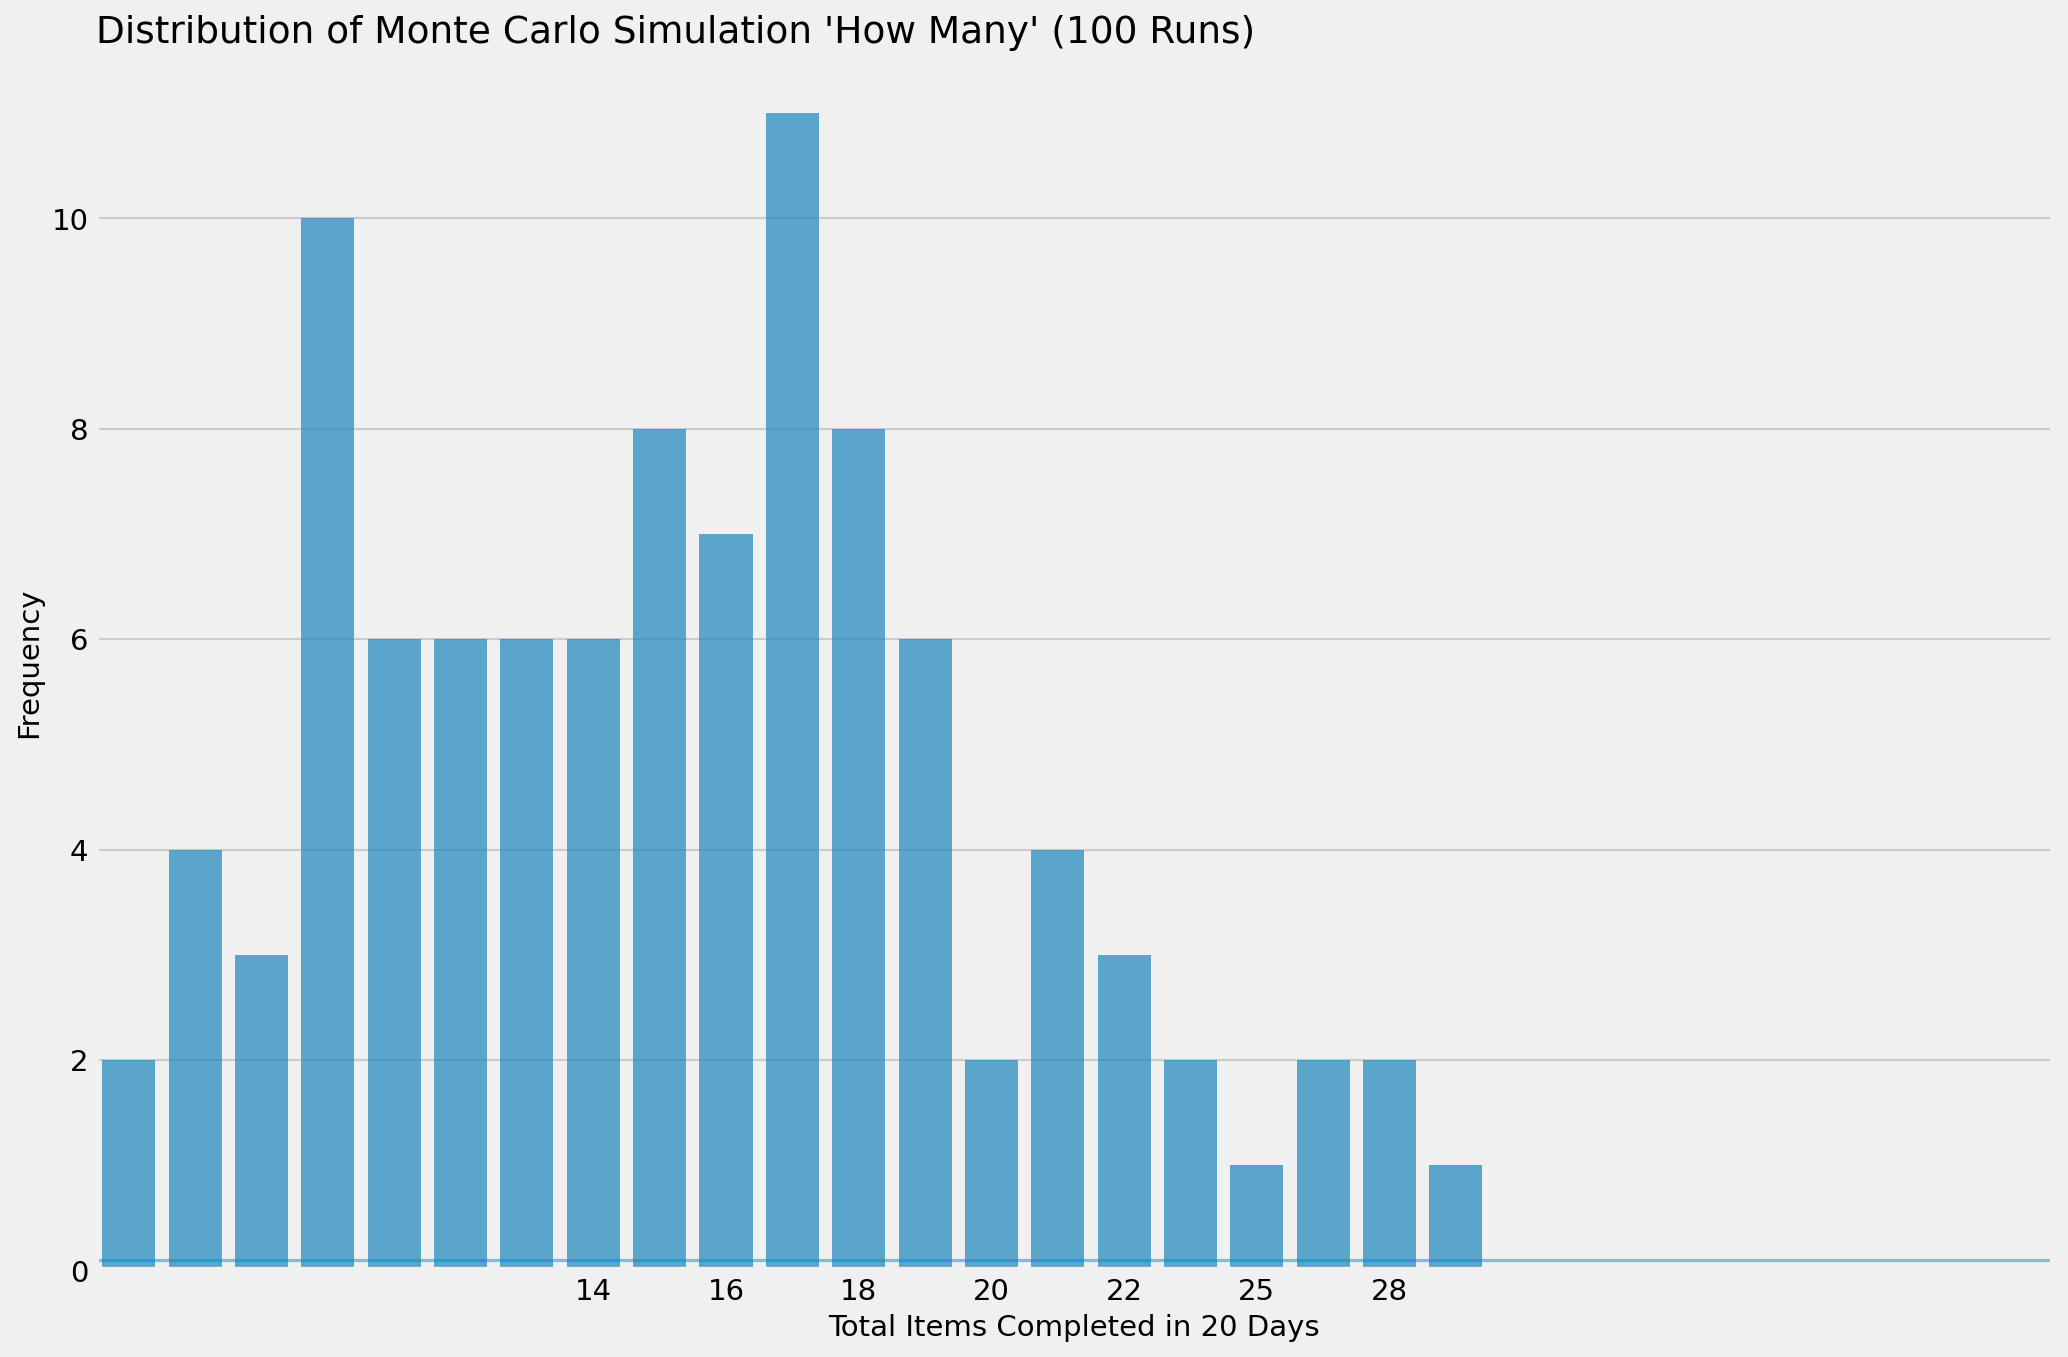

In [52]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Frequency', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'normal'})

ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.axhline(y=SIMULATIONS*0.001, alpha=.5);

In [53]:
ax.figure.savefig('images/distribution-montecarlo-how.png')

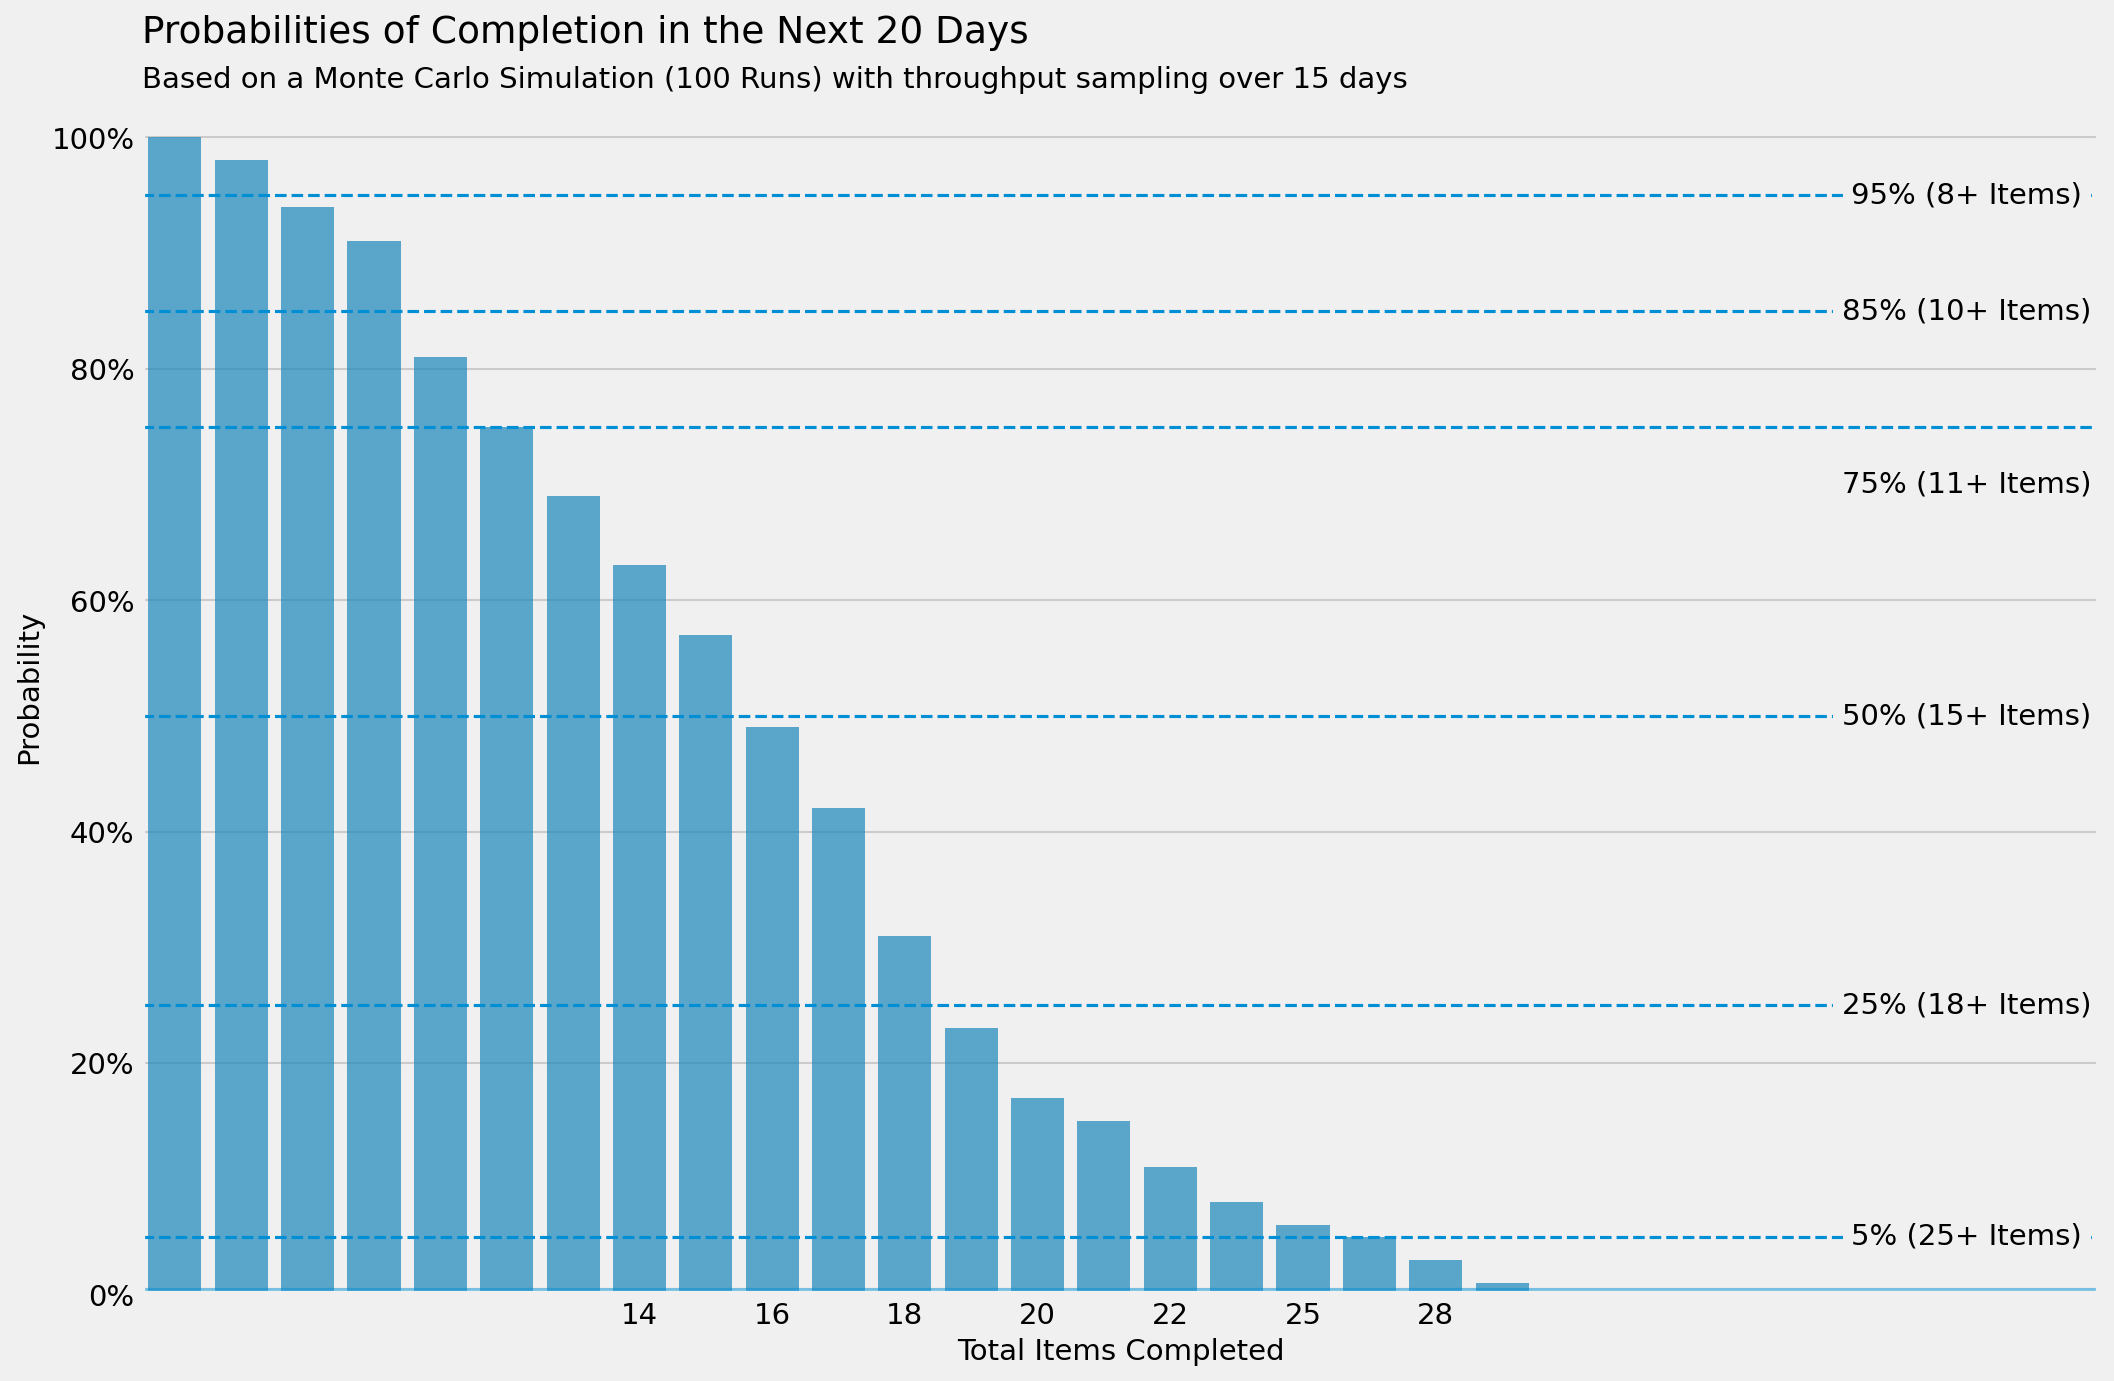

In [54]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Probability', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Probabilities of Completion in the Next {SIMULATION_DAYS} Days", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})
ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Items Completed')

ax.axhline(y=0.5, alpha=.5)
ax.axhline(y=5,   linestyle='--')
ax.axhline(y=25,  linestyle='--')
ax.axhline(y=50,  linestyle='--')
ax.axhline(y=75,  linestyle='--')
ax.axhline(y=85,  linestyle='--')
ax.axhline(y=95,  linestyle='--')

label_xpos = distribution_how['Items'].max()-2

ax.text(y=5, x=label_xpos, s=f'5%% (%d+ Items)' % samples.Items.quantile(0.95),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=label_xpos, s=f'25%% (%d+ Items)' % samples.Items.quantile(0.75),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=label_xpos, s=f'50%% (%d+ Items)' % samples.Items.quantile(0.5),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=70, x=label_xpos, s=f'75%% (%d+ Items)' % samples.Items.quantile(0.25),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%']);

In [55]:
ax.figure.savefig('images/forecast-montecarlo-how.png')

### Correlation

In [56]:
issue_data = issue_data.dropna(subset=['issue_points']) 
issue_data = issue_data.dropna(subset=['cycle_time_days'])
issue_data = issue_data.dropna(subset=['lead_time_days'])

points = issue_data['issue_points']
cycle_time_days = issue_data['cycle_time_days']
lead_time_days = issue_data['lead_time_days']

/Users/eugenemenski/PycharmProjects/jira-flow-metrics/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


          n   r  CI95%  p-val  BF10  power
pearson  26 NaN    NaN    NaN   NaN    NaN
correlation is NOT significant


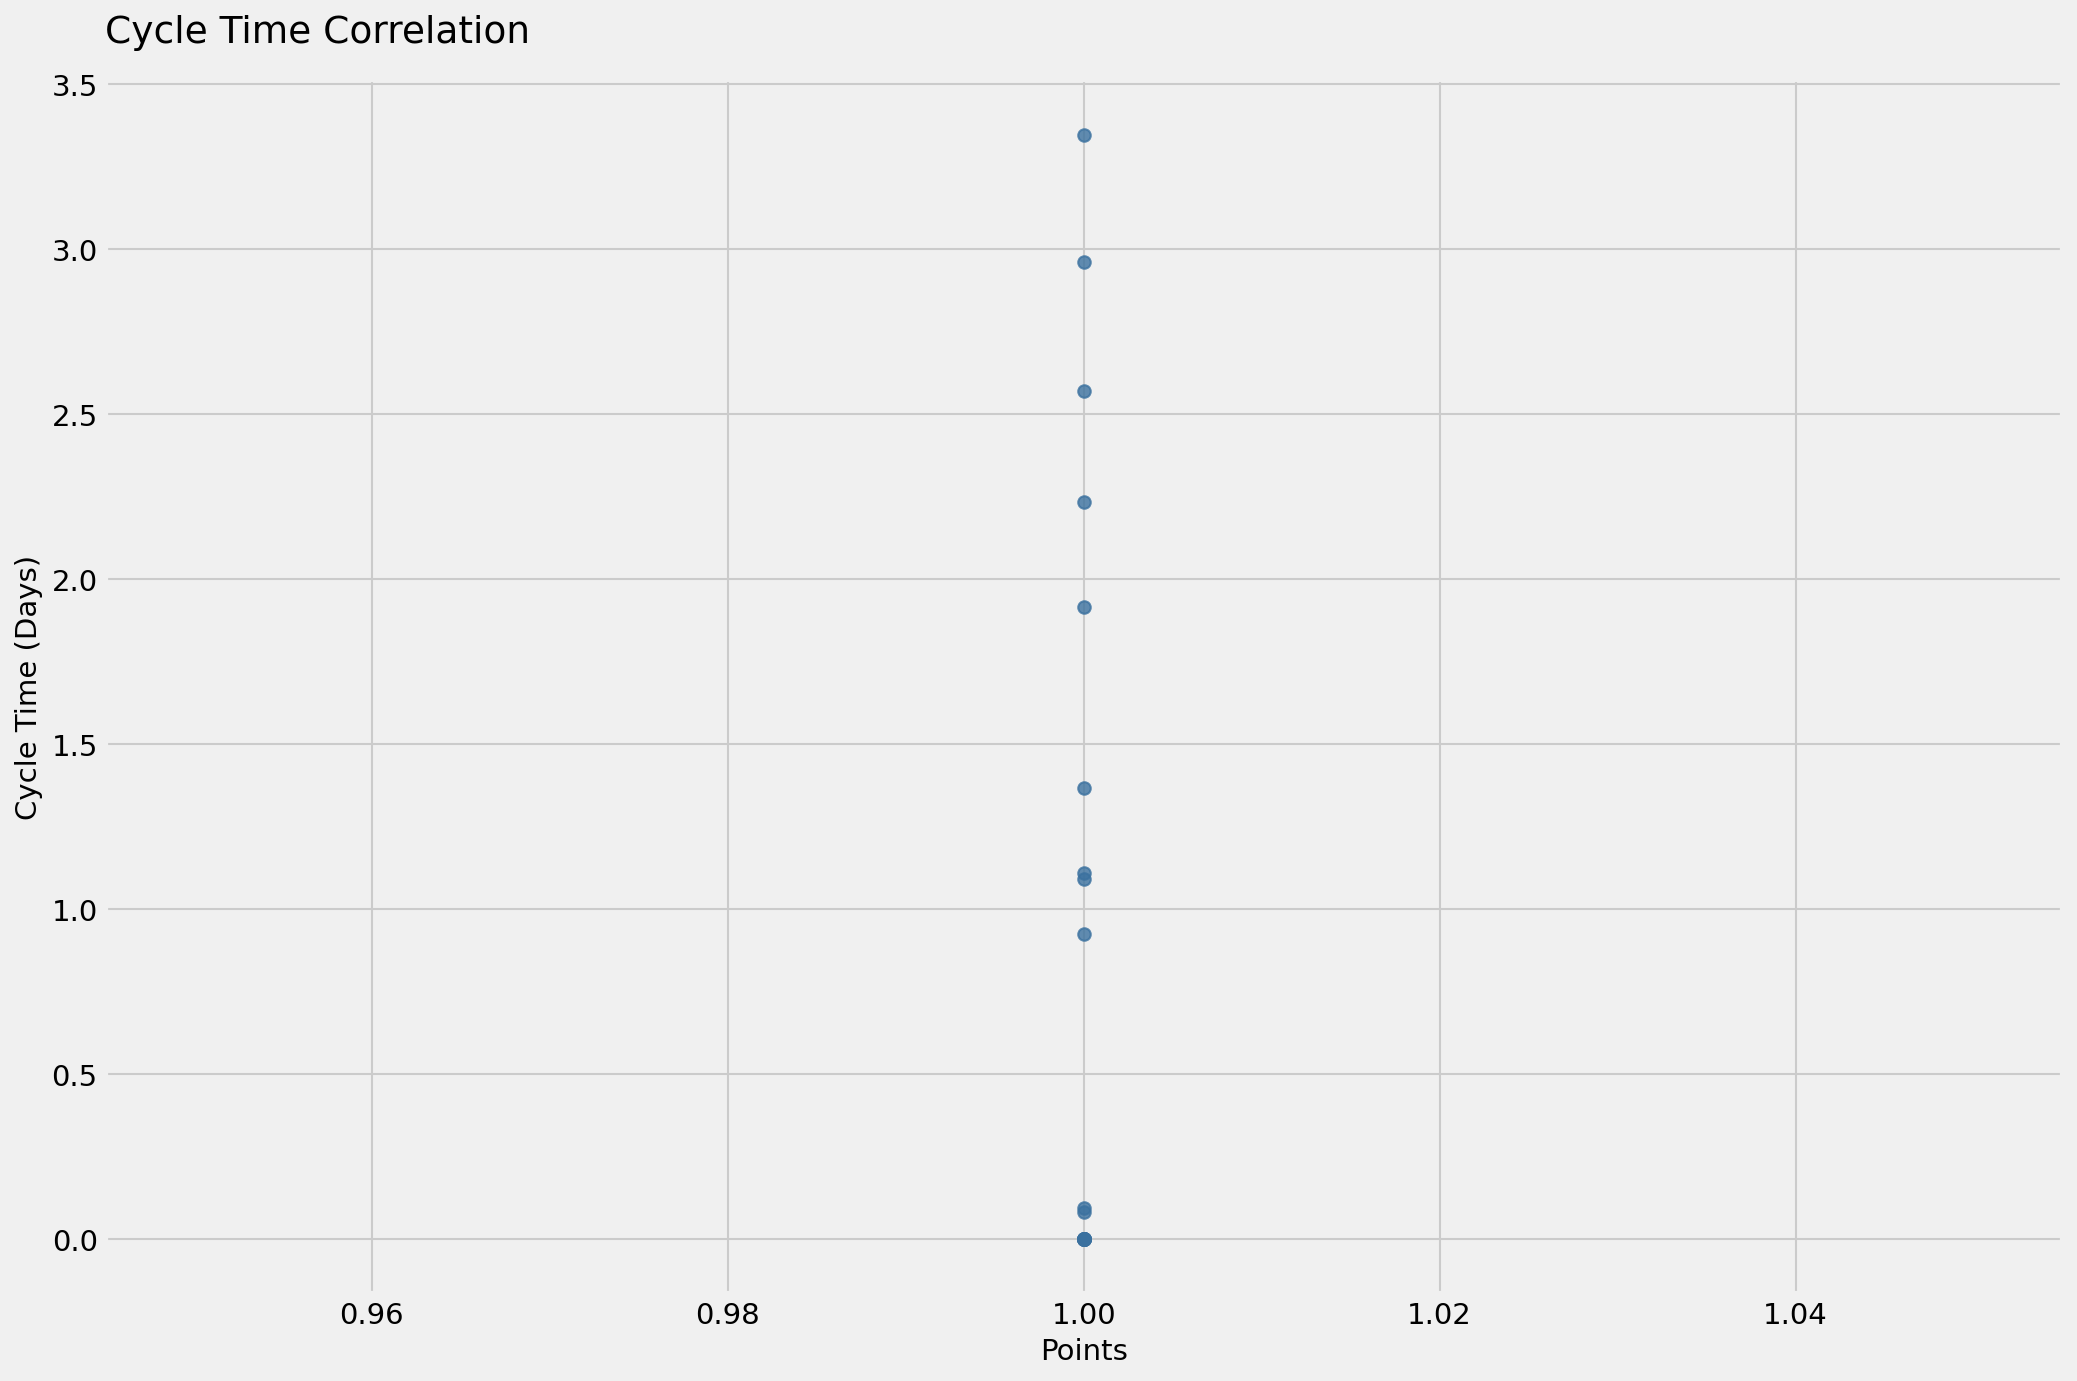

In [57]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
ax = analysis.plot_correlation(points, cycle_time_days)
ax.set_title("Cycle Time Correlation", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})
ax.set_ylabel('Cycle Time (Days)')
ax.set_xlabel('Points')
cor = analysis.process_correlation(points, cycle_time_days)
print(cor)
print('correlation is significant' if cor['p-val'].iat[0] < 0.05 else 'correlation is NOT significant')

In [58]:
ax.figure.savefig('images/correlation-lead-time.png')

/Users/eugenemenski/PycharmProjects/jira-flow-metrics/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


          n   r  CI95%  p-val  BF10  power
pearson  26 NaN    NaN    NaN   NaN    NaN
correlation is NOT significant


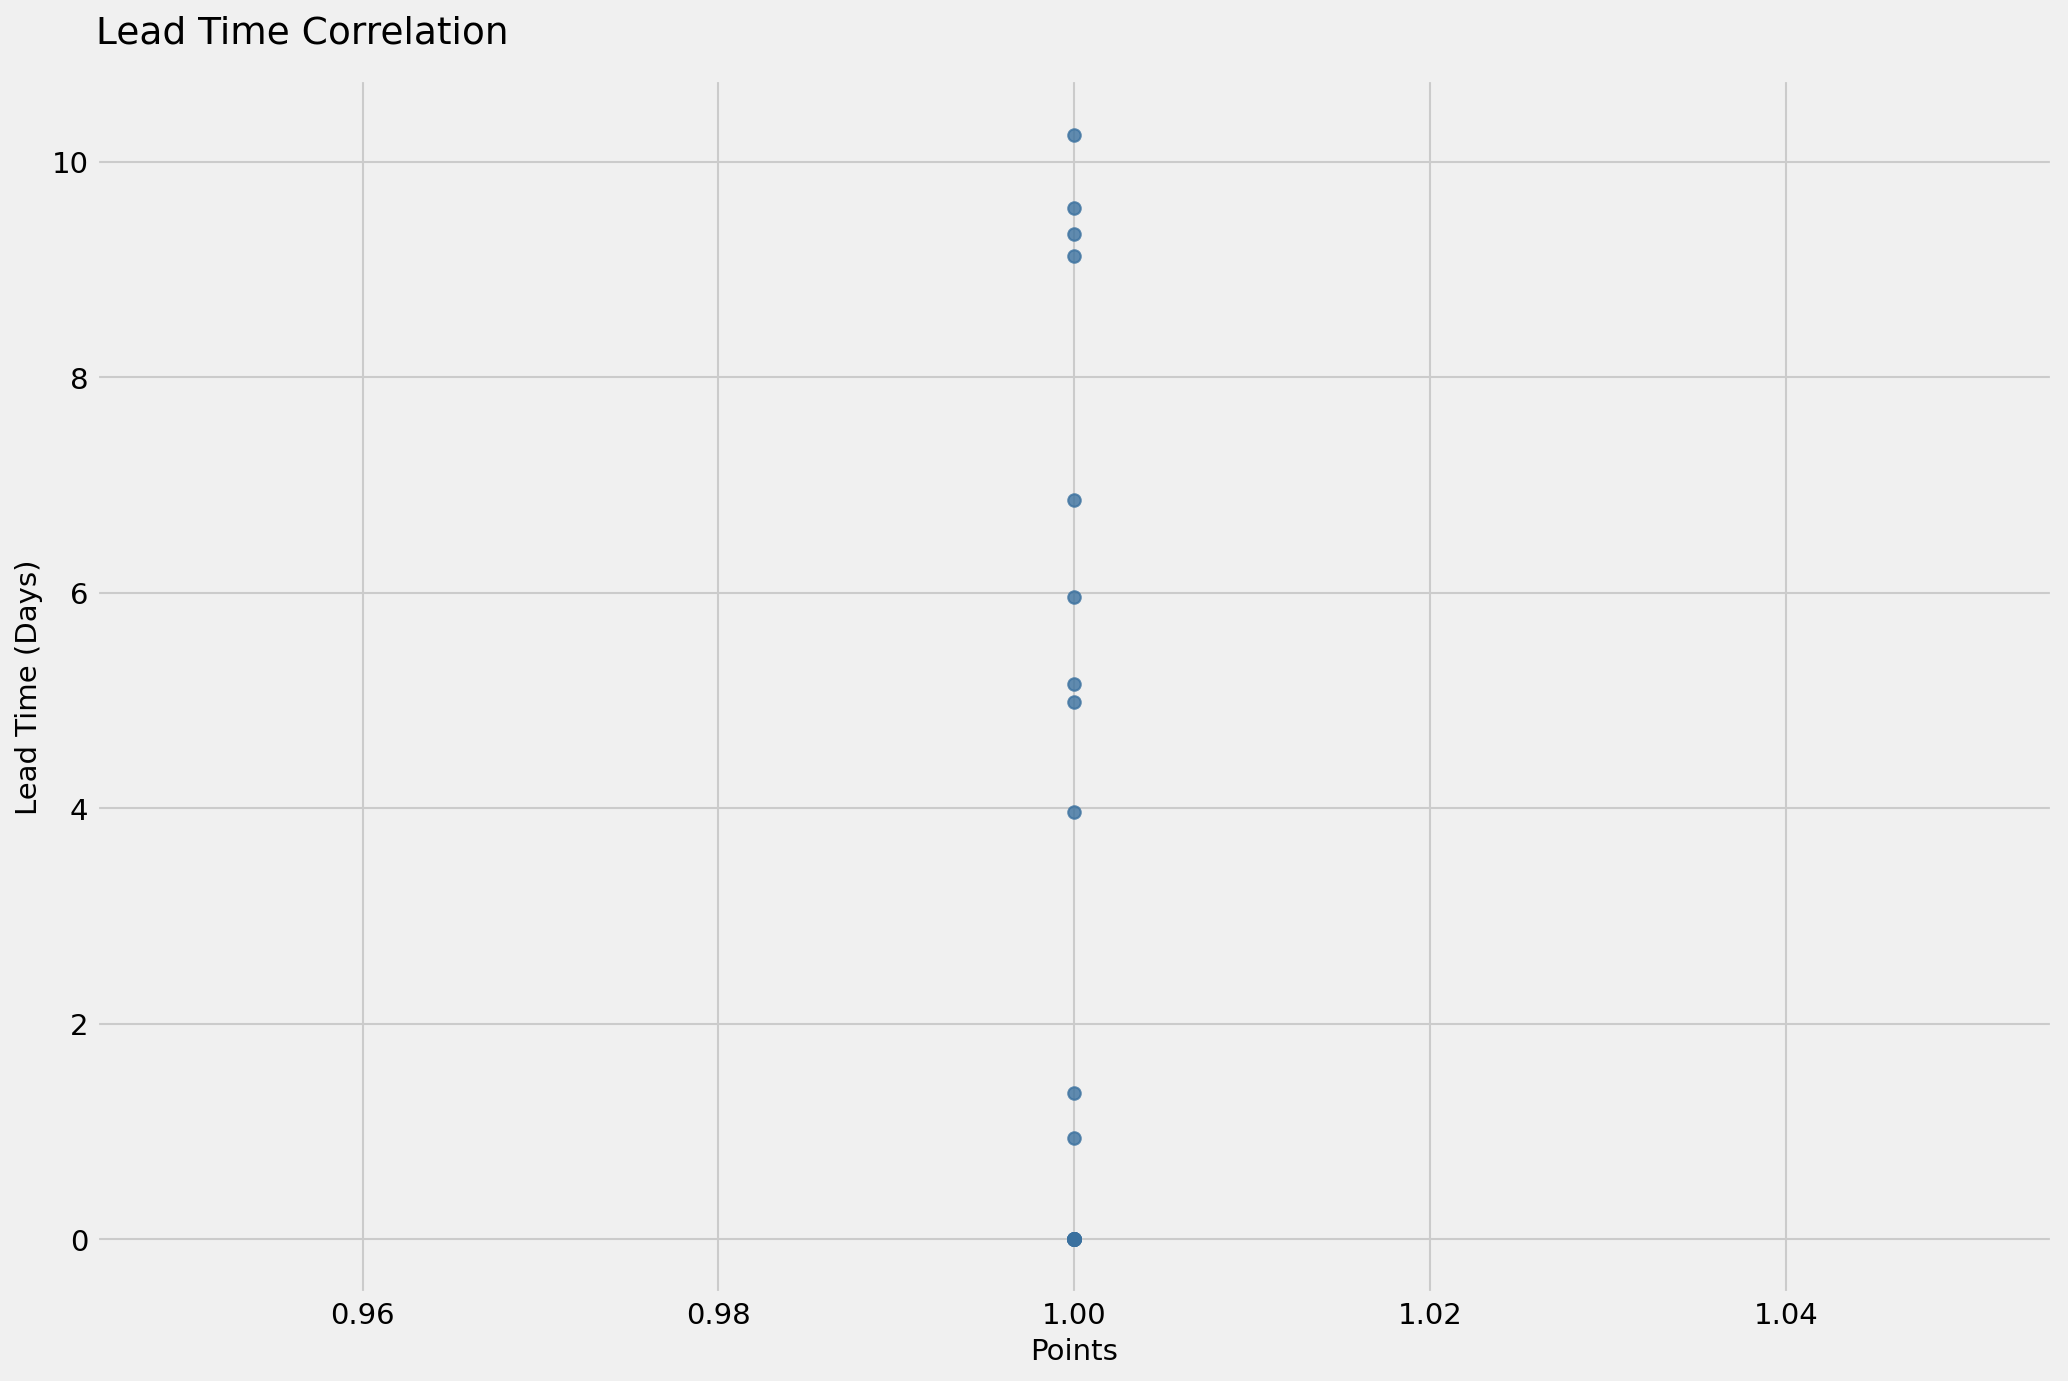

In [59]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
ax = analysis.plot_correlation(points, lead_time_days)
ax.set_title("Lead Time Correlation", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})
ax.set_ylabel('Lead Time (Days)')
ax.set_xlabel('Points')
cor = analysis.process_correlation(points, lead_time_days)
print(cor)
print('correlation is significant' if cor['p-val'].iat[0] < 0.05 else 'correlation is NOT significant')

In [60]:
ax.figure.savefig('images/correlation-lead-time.png')